In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

warnings.filterwarnings('ignore')

/var/folders/d7/x979bykd2dlfs7dc2t93ny0m0000gn/T/ipykernel_84711/1219156344.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
! pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 8.4 MB/s eta 0:00:01


In [20]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

zsh:1: command not found: nvidia-smi


## FE Team data

In [70]:
train_home_team_statistics_df = pd.read_csv('Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('Train_Data/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('Train_Data/Y_train.csv', index_col=0)
train_scores_supp = pd.read_csv('benchmark_and_extras/Y_train_supp.csv', index_col=0)


train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

train_data = train_data.fillna(train_data.median())


test_home = pd.read_csv('Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('Test_Data/test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)

test_data = test_data.fillna(test_data.median())



In [120]:
groups = np.array(train_home_team_statistics_df["TEAM_NAME"])

In [72]:
def combine_outcomes(row):
    if row['HOME_WINS'] == 1:
        return 1
    elif row['DRAW'] == 1:
        return 0
    elif row['AWAY_WINS'] == 1:
        return 2

train_scores['Outcome'] = train_scores.apply(combine_outcomes, axis=1)
train_new_y = train_scores['Outcome']

### Viz

In [25]:

def summarize_dataframe(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['missing#'] = df.isna().sum().values*100
    summary_df['missing%'] = (df.isna().sum().values*100)/len(df)
    summary_df['uniques'] = df.nunique().values
    summary_df['first_value'] = df.iloc[0].values
    summary_df['last_value'] = df.iloc[len(df)-1].values
    summary_df['count'] = df.count().values
    #sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    summary_df['min'] = desc['min']
    summary_df['max'] = desc['max']
    summary_df['mean'] = desc['mean']
    return summary_df

summarize_dataframe(train_home).style.background_gradient(cmap='Blues')


<Axes: >

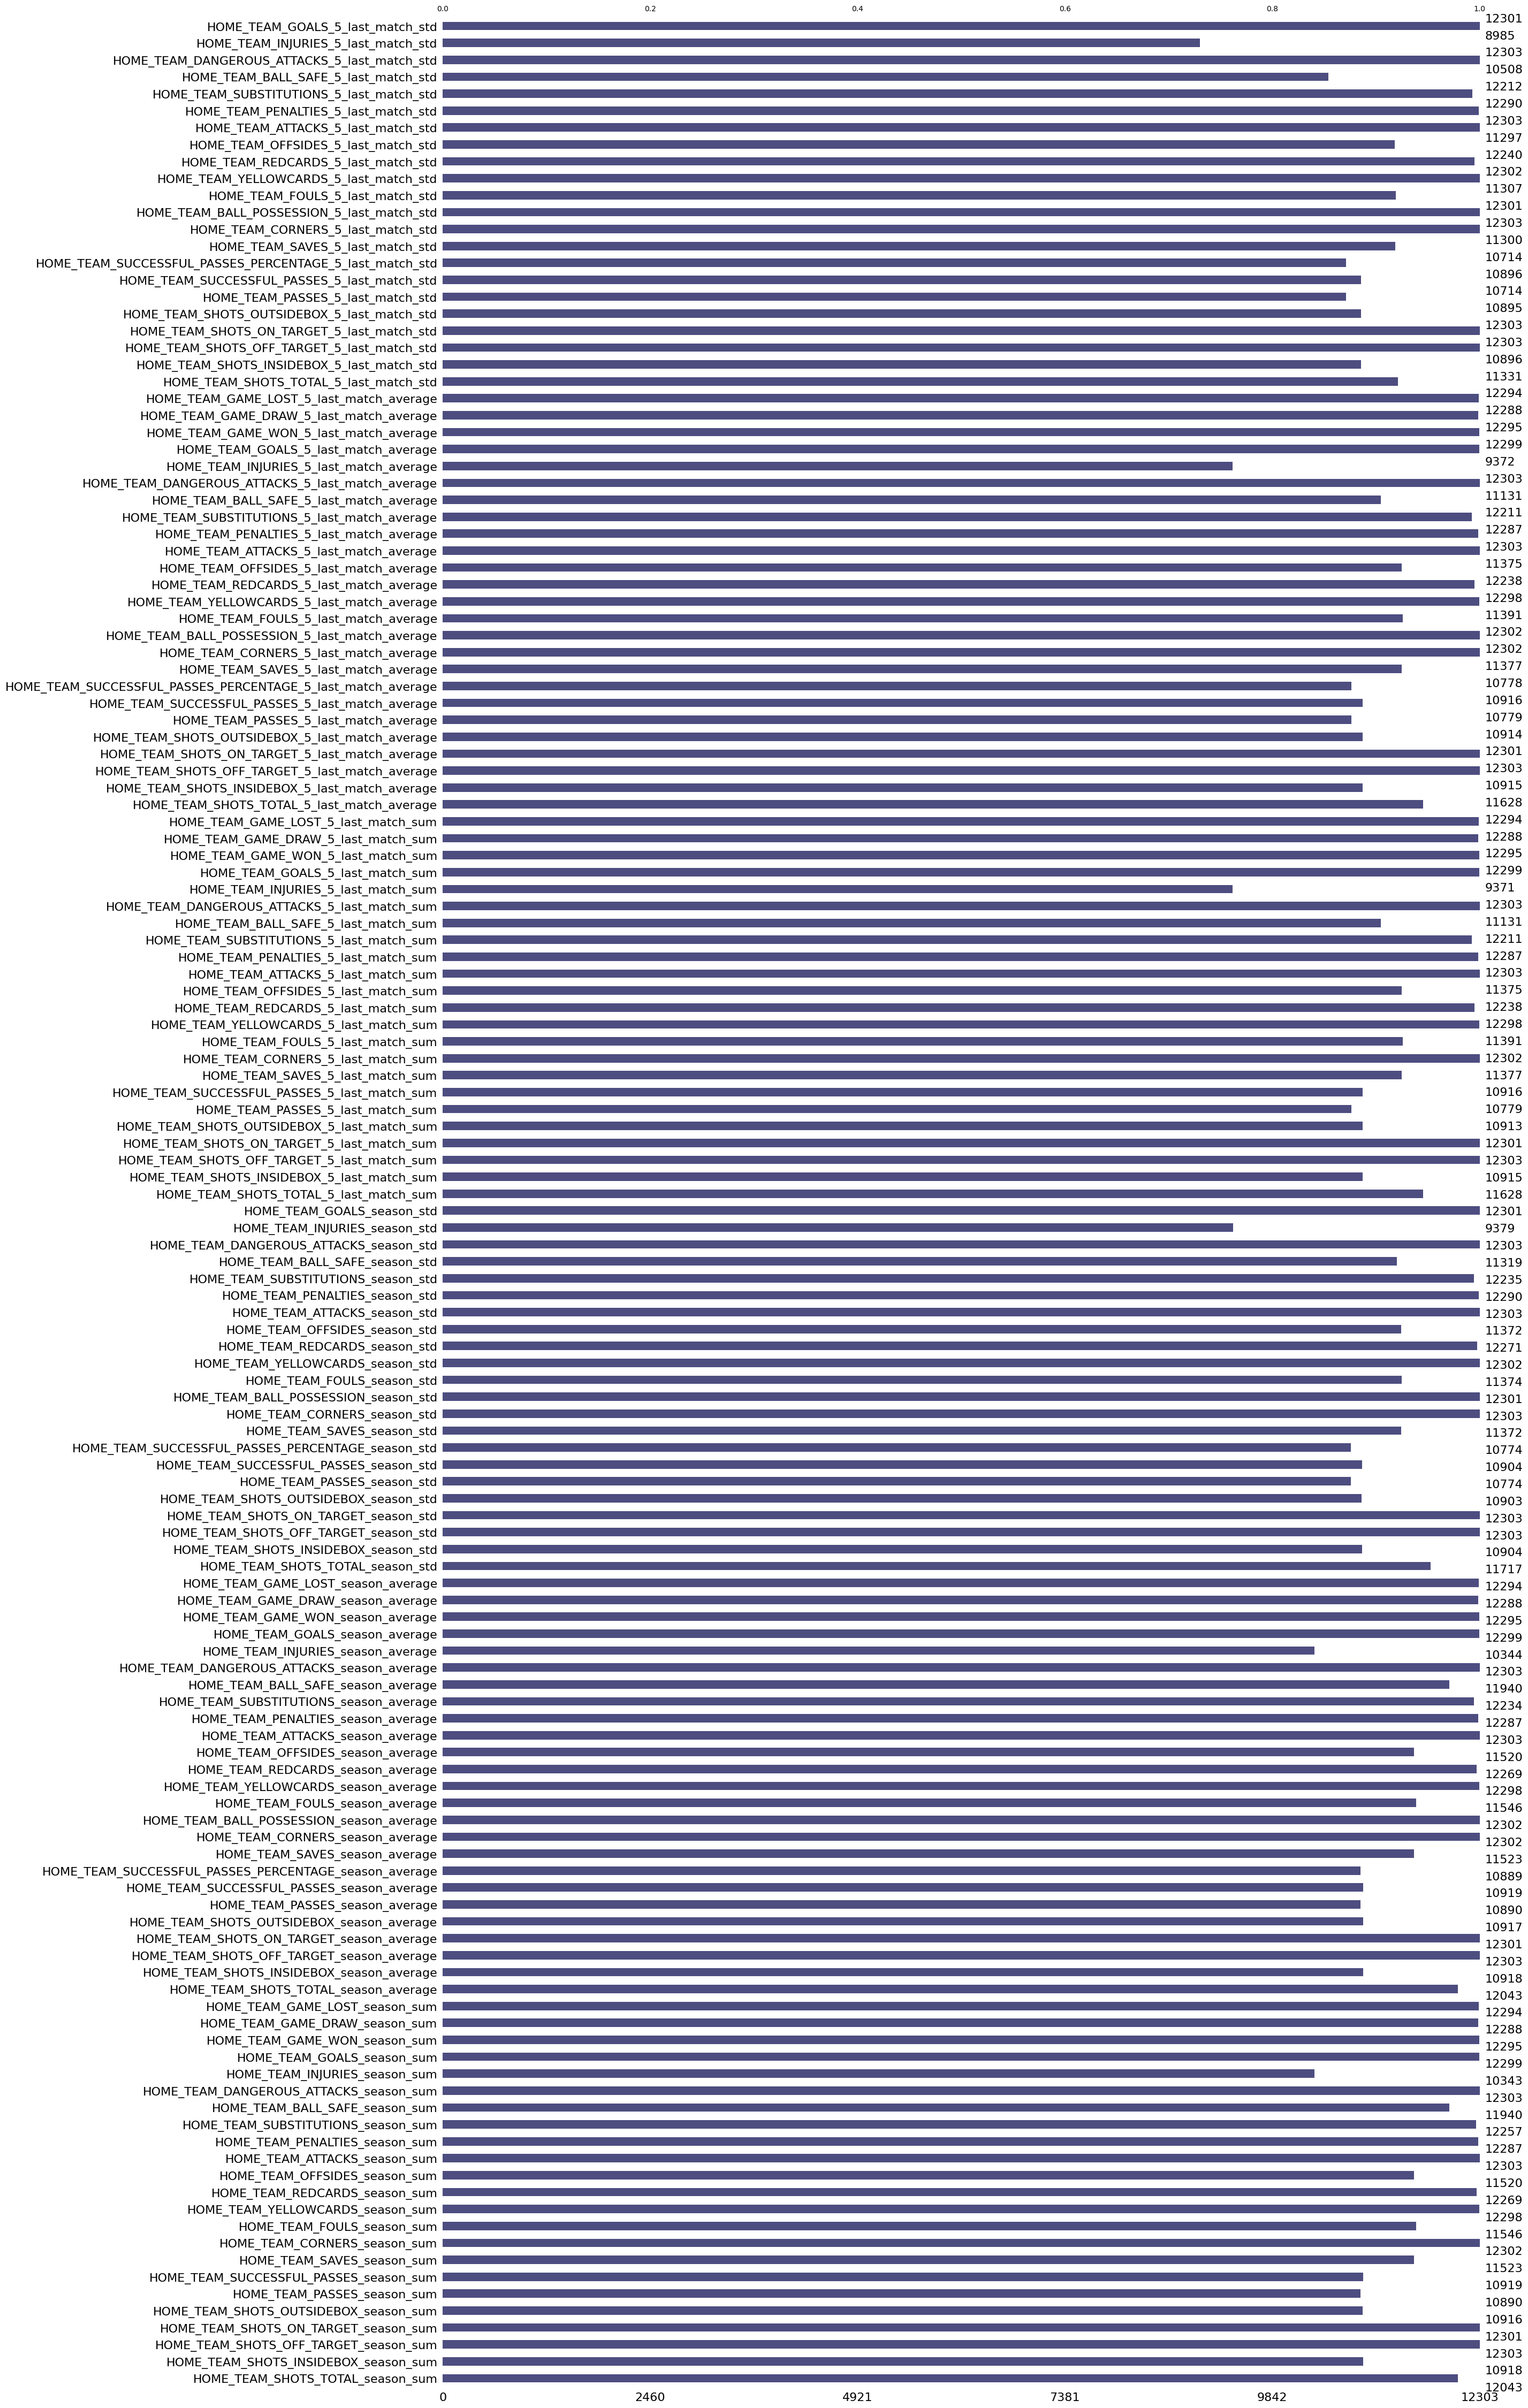

In [27]:
import missingno as msno
msno.bar(train_home, color=(0.3,0.3,0.5))

#### Correlation between features

In [ ]:

# sns.set_theme(style="white")

# d = train_home.copy()
# # d = d[['HOME_TEAM_SHOTS_TOTAL_season_sum',
# #        'HOME_TEAM_SHOTS_INSIDEBOX_season_sum',
# #        'HOME_TEAM_SHOTS_OFF_TARGET_season_sum',
# #        'HOME_TEAM_SHOTS_ON_TARGET_season_sum',
# #        'HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum', 'HOME_TEAM_PASSES_season_sum',
# #        'HOME_TEAM_SUCCESSFUL_PASSES_season_sum']]
# # d = d.drop(
# #     columns=['HOME_TEAM_SHOTS_TOTAL_season_sum',
# #        'HOME_TEAM_SHOTS_INSIDEBOX_season_sum',
# #        'HOME_TEAM_SHOTS_OFF_TARGET_season_sum',
# #        'HOME_TEAM_SHOTS_ON_TARGET_season_sum',
# #        'HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum', 'HOME_TEAM_PASSES_season_sum',
# #        'HOME_TEAM_SUCCESSFUL_PASSES_season_sum'
# #             ]
# # )

# corr = d.corr()

# d.fillna(0, inplace=True)

# mask = np.triu(np.ones_like(corr, dtype=bool))

# f, ax = plt.subplots(figsize=(15, 12))

# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=False,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
import sweetviz
train_data_all = pd.concat([train_home, train_scores['Outcome']], axis=1)

my_report = sweetviz.compare([train_data_all, "Train"], [test_home, "Test"], "Outcome")

KeyError: 'Outcome'

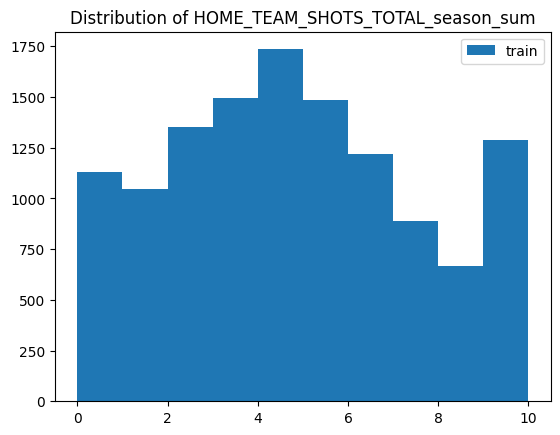

In [ ]:
plt.hist(train_data['HOME_TEAM_SHOTS_TOTAL_season_sum'], label='train');
plt.legend();
plt.title('Distribution of HOME_TEAM_SHOTS_TOTAL_season_sum');

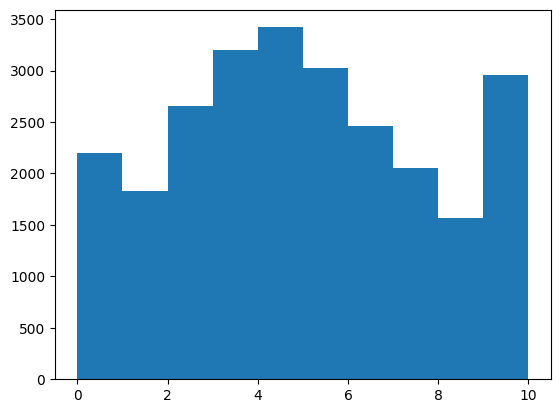

In [ ]:
plt.hist(test_data['HOME_TEAM_SHOTS_TOTAL_season_sum'], label='test');


In [ ]:
train_data.columns[140:160]

Index(['AWAY_TEAM_SHOTS_TOTAL_season_sum',
       'AWAY_TEAM_SHOTS_INSIDEBOX_season_sum',
       'AWAY_TEAM_SHOTS_OFF_TARGET_season_sum',
       'AWAY_TEAM_SHOTS_ON_TARGET_season_sum',
       'AWAY_TEAM_SHOTS_OUTSIDEBOX_season_sum', 'AWAY_TEAM_PASSES_season_sum',
       'AWAY_TEAM_SUCCESSFUL_PASSES_season_sum', 'AWAY_TEAM_SAVES_season_sum',
       'AWAY_TEAM_CORNERS_season_sum', 'AWAY_TEAM_FOULS_season_sum',
       'AWAY_TEAM_YELLOWCARDS_season_sum', 'AWAY_TEAM_REDCARDS_season_sum',
       'AWAY_TEAM_OFFSIDES_season_sum', 'AWAY_TEAM_ATTACKS_season_sum',
       'AWAY_TEAM_PENALTIES_season_sum', 'AWAY_TEAM_SUBSTITUTIONS_season_sum',
       'AWAY_TEAM_BALL_SAFE_season_sum',
       'AWAY_TEAM_DANGEROUS_ATTACKS_season_sum',
       'AWAY_TEAM_INJURIES_season_sum', 'AWAY_TEAM_GOALS_season_sum'],
      dtype='object')

In [ ]:
train_data_all = pd.concat([pythagorean_train_small, train_scores['HOME_WINS']], axis=1)
train_data_all

PYTHAGOREAN_5_last_match_sum  PYTHAGOREAN_5_last_match_average  \
ID                                                                      
0                      1.248355e-01                      1.248355e-01   
1                      9.999999e-01                      9.999999e-01   
2                      3.369013e-01                      3.369013e-01   
3                      9.999999e-01                      9.999999e-01   
4                      2.092724e-01                      2.092724e-01   
...                             ...                               ...   
12298                  1.248355e-01                      1.248355e-01   
12299                  4.329063e-01                      4.329063e-01   
12300                  5.495402e-08                      5.495402e-08   
12301                  3.797495e-01                      3.797495e-01   
12302                  7.907276e-01                      7.907276e-01   

       PYTHAGOREAN_season_sum  PYTHAGOREAN_season_average  HOME_WINS  
ID                                                                    
0                    0.078438                    0.085360          0  
1                    0.902472                    0.881246          0  
2                    0.097528                    0.118754          0  
3                    0.999999                    0.999999          1  
4                    0.322640                    0.243873          0  
...                       ...                         ...        ...  
12298                0.078438                    0.085360          0  
12299                0.128177                    0.136402          0  
12300                0.184925                    0.193429          0  
12301                0.366658                    0.371416          1  
12302                0.633342                    0.628584          1  

[12303 rows x 5 columns]

In [ ]:
train_data_all.columns

Index(['PYTHAGOREAN_5_last_match_sum', 'PYTHAGOREAN_5_last_match_average',
       'PYTHAGOREAN_season_sum', 'PYTHAGOREAN_season_average', 'Outcome'],
      dtype='object')

In [ ]:
p=12.4
train_data_all['PYTH_HOME'] = (train_data_all['HOME_TEAM_GAME_WON_5_last_match_sum'] ** p) / ((train_data_all['HOME_TEAM_GAME_WON_5_last_match_sum'] ** p) + (train_data_all['HOME_TEAM_GAME_LOST_5_last_match_sum'] ** p))

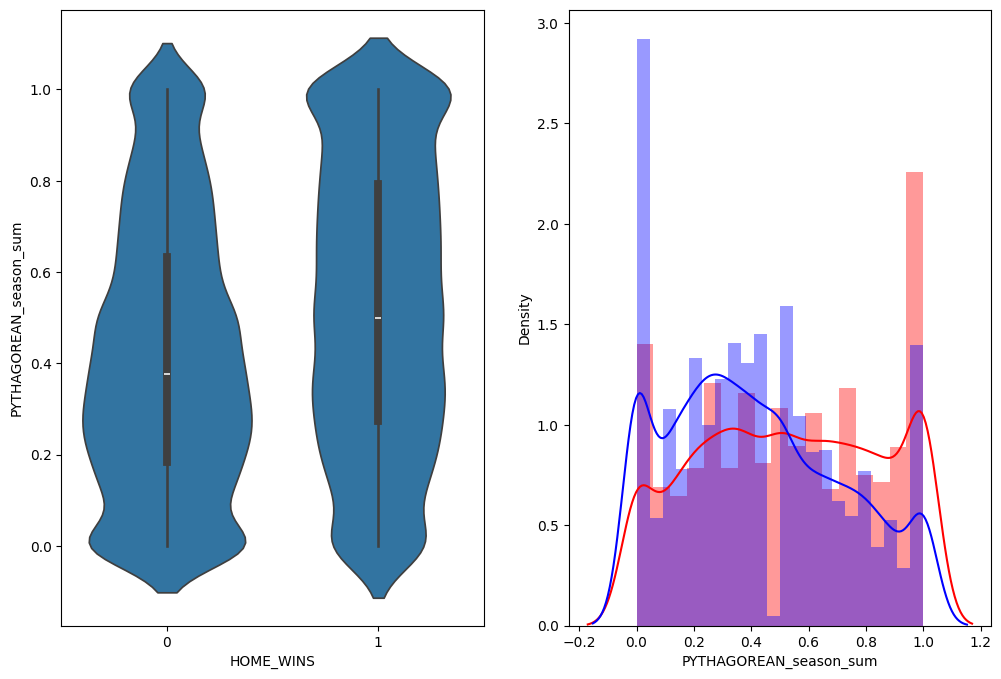

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 8))
feat = "PYTHAGOREAN_season_sum"
plt.subplot(1,2,1)
sns.violinplot(x = 'HOME_WINS', y = feat, data = train_data_all[0:])

plt.subplot(1,2,2)
sns.distplot(train_data_all[train_data_all['HOME_WINS'] == 1.0][feat][0:] , label = "1", color = 'red')
sns.distplot(train_data_all[train_data_all['HOME_WINS'] == 0.0][feat][0:] , label = "0" , color = 'blue' )
sns.distplot(train_data_all[train_data_all['HOME_WINS'] == 2.0][feat][0:] , label = "2" , color = 'yellow' )

plt.show()

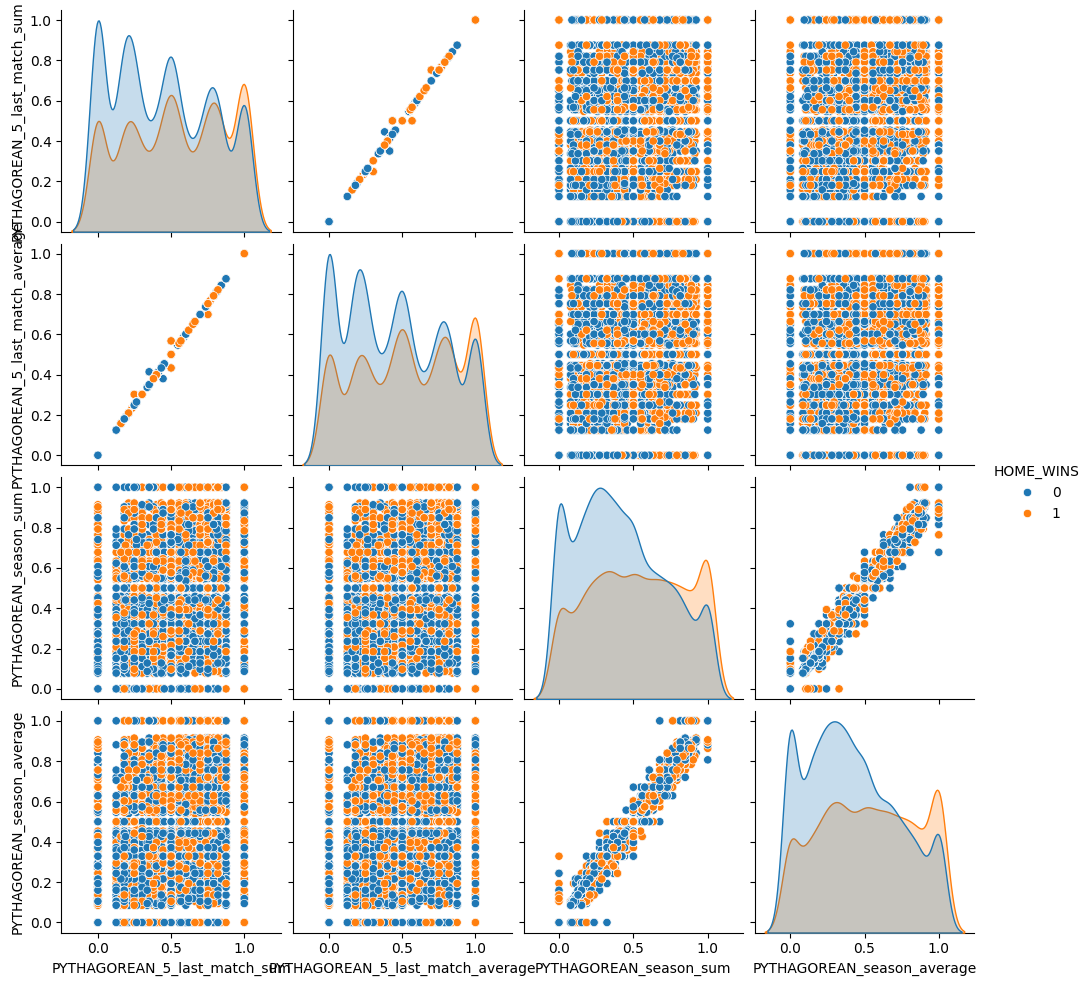

In [ ]:
n = train_data_all.shape[0]
sns.pairplot(train_data_all[['PYTHAGOREAN_5_last_match_sum', 'PYTHAGOREAN_5_last_match_average',
       'PYTHAGOREAN_season_sum', 'PYTHAGOREAN_season_average', 'HOME_WINS']][0:n], hue='HOME_WINS', vars=['PYTHAGOREAN_5_last_match_sum', 'PYTHAGOREAN_5_last_match_average',
       'PYTHAGOREAN_season_sum', 'PYTHAGOREAN_season_average'])
plt.show()

### Preprocessing

In [ ]:
def add_missing_indicators(df, missing_threshold=0.01, consider_columns=None):
    if consider_columns is None:
        consider_columns = df.columns

    missing_stats = df[consider_columns].isna().mean()
    features_with_lots_of_nans = missing_stats[missing_stats > missing_threshold].index.tolist()
    print(features_with_lots_of_nans)
    for feature in features_with_lots_of_nans:
        indicator_feature_name = f"{feature}_is_nan"
        df[indicator_feature_name] = df[feature].isna().astype(int)
    return df

def process_dataframe(df):
    selected_features = df.columns[2:]
    df['Selected_NaN_Count'] = df[selected_features].isna().sum(axis=1)

    df_columns = df.iloc[:,2:].columns.to_list()
    for feat in df_columns:
        df[feat] = df.groupby('TEAM_NAME')[feat].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x.mean()))

    df.iloc[:, 2:] = df.iloc[:, 2:].fillna(
        df.iloc[:, 2:].mean()
    )

    return df

In [ ]:
train_home_team_statistics_df = add_missing_indicators(train_home_team_statistics_df, missing_threshold=0.1)
train_home_team_statistics_df = process_dataframe(train_home_team_statistics_df)


train_away_team_statistics_df = add_missing_indicators(train_away_team_statistics_df, missing_threshold=0.1)
train_away_team_statistics_df = process_dataframe(train_away_team_statistics_df)

## Pythagorean Feat

### Home WON vs LOST

In [28]:
def optimize_p(home_values, away_values, target, p_values):
    best_p = None
    best_corr = 0
    for p in p_values:
        pythagorean_feature = calculate_pythagorean_feature(home_values, away_values, p)
        corr, _ = pearsonr(pythagorean_feature, target)
        if abs(corr) > abs(best_corr):
            best_corr = abs(corr)
            best_p = p
    return best_p, best_corr

def calculate_pythagorean_feature(home_values, away_values, p):
    epsilon = 1e-5
    pythagorean_feature = (home_values + epsilon) ** p / ((home_values + epsilon) ** p + (away_values + epsilon) ** p)
    return np.nan_to_num(pythagorean_feature, nan=0.0, posinf=0.0, neginf=0.0)


feature_pairs = [
    ('HOME_TEAM_GAME_WON_5_last_match_sum', 'HOME_TEAM_GAME_LOST_5_last_match_sum'),
    ('HOME_TEAM_GAME_WON_5_last_match_average', 'HOME_TEAM_GAME_LOST_5_last_match_average'),
    ('HOME_TEAM_GAME_WON_season_sum', 'HOME_TEAM_GAME_LOST_season_sum'),
    ('HOME_TEAM_GAME_WON_season_average', 'HOME_TEAM_GAME_LOST_season_average')
]

target = train_scores['HOME_WINS']
p_values = np.arange(1.01, 6.01, 0.01)

pythagorean_train_small_home = pd.DataFrame(index=train_data.index)

optimal_p_values = {}

for home_feat, away_feat in feature_pairs:
    home_values = train_data[home_feat]
    away_values = train_data[away_feat]

    best_p, best_corr = optimize_p(home_values, away_values, target, p_values)
    optimal_p_values[home_feat] = best_p

    pythagorean_feature = calculate_pythagorean_feature(home_values, away_values, best_p)

    new_feature_name = f"PYTHAGOREAN_HOME_{home_feat.replace('HOME_TEAM_GAME_WON_', '')}"
    pythagorean_train_small_home[new_feature_name] = pythagorean_feature

    print(f"Best p for {home_feat} vs. {away_feat}: {best_p} (Correlation: {best_corr})")


Best p for HOME_TEAM_GAME_WON_5_last_match_sum vs. HOME_TEAM_GAME_LOST_5_last_match_sum: 1.2100000000000002 (Correlation: 0.1329158886206568)
Best p for HOME_TEAM_GAME_WON_5_last_match_average vs. HOME_TEAM_GAME_LOST_5_last_match_average: 1.2100000000000002 (Correlation: 0.13286960988518587)
Best p for HOME_TEAM_GAME_WON_season_sum vs. HOME_TEAM_GAME_LOST_season_sum: 1.07 (Correlation: 0.17785929211423798)
Best p for HOME_TEAM_GAME_WON_season_average vs. HOME_TEAM_GAME_LOST_season_average: 1.03 (Correlation: 0.1753849817098731)


In [29]:
pythagorean_test_small_home = pd.DataFrame(index=test_data.index)

for home_feat, away_feat in feature_pairs:
    home_values = test_data[home_feat]
    away_values = test_data[away_feat]
    best_p = optimal_p_values[home_feat]

    pythagorean_feature = calculate_pythagorean_feature(home_values, away_values, best_p)

    new_feature_name = f"PYTHAGOREAN_HOME_{home_feat.replace('HOME_TEAM_GAME_WON_', '')}"
    pythagorean_test_small_home[new_feature_name] = pythagorean_feature

In [30]:
pythagorean_test_small_home

PYTHAGOREAN_HOME_5_last_match_sum  \
ID                                         
12303                       5.495402e-08   
12304                       6.497857e-01   
12305                       8.199249e-01   
12306                       4.450704e-01   
12307                       9.999999e-01   
...                                  ...   
37666                       5.000000e-01   
37667                       7.518882e-01   
37668                       9.999999e-01   
37669                       2.481118e-01   
37670                       3.369013e-01   

       PYTHAGOREAN_HOME_5_last_match_average  PYTHAGOREAN_HOME_season_sum  \
ID                                                                          
12303                           5.495402e-08                 3.801888e-07   
12304                           6.497857e-01                 5.000000e-01   
12305                           8.199249e-01                 9.999996e-01   
12306                           4.450704e-01                 9.215616e-01   
12307                           9.999999e-01                 3.666578e-01   
...                                      ...                          ...   
37666                           5.000000e-01                 9.999995e-01   
37667                           7.518882e-01                 5.000000e-01   
37668                           9.999999e-01                 6.773600e-01   
37669                           2.481118e-01                 3.226400e-01   
37670                           3.369013e-01                 6.773600e-01   

       PYTHAGOREAN_HOME_season_average  
ID                                      
12303                     6.606923e-07  
12304                     5.000000e-01  
12305                     9.999993e-01  
12306                     9.146400e-01  
12307                     4.264594e-01  
...                                ...  
37666                     9.999990e-01  
37667                     5.572077e-01  
37668                     6.712711e-01  
37669                     3.287289e-01  
37670                     7.198618e-01  

[25368 rows x 4 columns]

### AWAY WON vs LOST

In [31]:
feature_pairs = [
    ('AWAY_TEAM_GAME_WON_5_last_match_sum', 'AWAY_TEAM_GAME_LOST_5_last_match_sum'),
    ('AWAY_TEAM_GAME_WON_5_last_match_average', 'AWAY_TEAM_GAME_LOST_5_last_match_average'),
    ('AWAY_TEAM_GAME_WON_season_sum', 'AWAY_TEAM_GAME_LOST_season_sum'),
    ('AWAY_TEAM_GAME_WON_season_average', 'AWAY_TEAM_GAME_LOST_season_average')
]

target = train_scores['AWAY_WINS']
p_values = np.arange(1.01, 6.01, 0.01)

pythagorean_train_small_away = pd.DataFrame(index=train_data.index)

optimal_p_values = {}

for home_feat, away_feat in feature_pairs:
    home_values = train_data[home_feat]
    away_values = train_data[away_feat]

    best_p, best_corr = optimize_p(home_values, away_values, target, p_values)
    optimal_p_values[home_feat] = best_p

    pythagorean_feature = calculate_pythagorean_feature(home_values, away_values, best_p)

    new_feature_name = f"PYTHAGOREAN_AWAY_{home_feat.replace('AWAY_TEAM_GAME_WON_', '')}"
    pythagorean_train_small_away[new_feature_name] = pythagorean_feature

    print(f"Best p for {home_feat} vs. {away_feat}: {best_p} (Correlation: {best_corr})")

Best p for AWAY_TEAM_GAME_WON_5_last_match_sum vs. AWAY_TEAM_GAME_LOST_5_last_match_sum: 1.05 (Correlation: 0.11031422312085015)
Best p for AWAY_TEAM_GAME_WON_5_last_match_average vs. AWAY_TEAM_GAME_LOST_5_last_match_average: 1.05 (Correlation: 0.11017448174283653)
Best p for AWAY_TEAM_GAME_WON_season_sum vs. AWAY_TEAM_GAME_LOST_season_sum: 1.06 (Correlation: 0.16201670436298624)
Best p for AWAY_TEAM_GAME_WON_season_average vs. AWAY_TEAM_GAME_LOST_season_average: 1.1400000000000001 (Correlation: 0.16186396075408216)


In [32]:
pythagorean_test_small_away = pd.DataFrame(index=test_data.index)

for home_feat, away_feat in feature_pairs:
    home_values = test_data[home_feat]
    away_values = test_data[away_feat]
    best_p = optimal_p_values[home_feat]

    pythagorean_feature = calculate_pythagorean_feature(home_values, away_values, best_p)

    new_feature_name = f"PYTHAGOREAN_AWAY_{home_feat.replace('AWAY_TEAM_GAME_WON_', '')}"
    pythagorean_test_small_away[new_feature_name] = pythagorean_feature

### Pyth HOME WINS

In [33]:
def optimize_p(home_feat, away_feat, target, p_values):
    best_p = None
    best_corr = 0

    for p in p_values:
        epsilon = 1e-5
        home_values = train_data[home_feat] + epsilon
        away_values = train_data[away_feat] + epsilon

        pythagorean_feature = (home_values ** p) / ((home_values ** p) + (away_values ** p))
        # pythagorean_feature = (home_values ** p)

        pythagorean_feature = np.nan_to_num(pythagorean_feature, nan=0.0, posinf=0.0, neginf=0.0)

        corr, _ = pearsonr(pythagorean_feature, target)

        if abs(corr) > abs(best_corr):
            best_corr = abs(corr)
            best_p = p

    return best_p, best_corr

p_values = np.arange(1.01, 6.01, 0.01)
optimal_p_values_home_wins = {}
optimal_corr = 0
for home_feat, away_feat in zip(train_home.columns, train_away.columns):
    best_p, best_corr = optimize_p(home_feat, away_feat, train_scores['HOME_WINS'], p_values)
    print(f"Best p for {home_feat} vs. {away_feat}: {best_p} (Correlation: {best_corr})")
    optimal_p_values_home_wins[home_feat] = best_p
    optimal_corr += best_corr

Best p for HOME_TEAM_SHOTS_TOTAL_season_sum vs. AWAY_TEAM_SHOTS_TOTAL_season_sum: 2.6600000000000015 (Correlation: 0.20613687345587922)
Best p for HOME_TEAM_SHOTS_INSIDEBOX_season_sum vs. AWAY_TEAM_SHOTS_INSIDEBOX_season_sum: 2.210000000000001 (Correlation: 0.225921484047376)
Best p for HOME_TEAM_SHOTS_OFF_TARGET_season_sum vs. AWAY_TEAM_SHOTS_OFF_TARGET_season_sum: 2.410000000000001 (Correlation: 0.15428541059958045)
Best p for HOME_TEAM_SHOTS_ON_TARGET_season_sum vs. AWAY_TEAM_SHOTS_ON_TARGET_season_sum: 2.5200000000000014 (Correlation: 0.2195775634375824)
Best p for HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum vs. AWAY_TEAM_SHOTS_OUTSIDEBOX_season_sum: 1.4700000000000004 (Correlation: 0.08967699809615337)
Best p for HOME_TEAM_PASSES_season_sum vs. AWAY_TEAM_PASSES_season_sum: 2.9600000000000017 (Correlation: 0.18062368856918876)
Best p for HOME_TEAM_SUCCESSFUL_PASSES_season_sum vs. AWAY_TEAM_SUCCESSFUL_PASSES_season_sum: 3.3000000000000016 (Correlation: 0.18281960786636312)
Best p for HOME

In [34]:
def calculate_pythagorean_feature(home_values, away_values, p):
    epsilon = 1e-5
    pythagorean_feature = (home_values + epsilon) ** p / ((home_values + epsilon) ** p + (away_values + epsilon) ** p)
    return np.nan_to_num(pythagorean_feature, nan=0.0, posinf=0.0, neginf=0.0)

pythagorean_train_df_home_wins = pd.DataFrame(index=train_data.index)

for home_feat, away_feat in zip(train_home.columns, train_away.columns):
    home_values = train_data[home_feat]
    away_values = train_data[away_feat]
    best_p = optimal_p_values_home_wins[home_feat]

    pythagorean_feature = calculate_pythagorean_feature(home_values, away_values, best_p)

    new_feature_name = f"PYTHAG_HOME_WINS_{home_feat.replace('HOME_', '')}"
    pythagorean_train_df_home_wins[new_feature_name] = pythagorean_feature





```
# Ce texte est au format code
```



In [35]:
pythagorean_test_df_home_wins = pd.DataFrame(index=test_data.index)

for home_feat, away_feat in zip(test_home.columns, test_away.columns):
    home_values = test_data[home_feat]
    away_values = test_data[away_feat]
    best_p = optimal_p_values_home_wins[home_feat]

    pythagorean_feature = calculate_pythagorean_feature(home_values, away_values, best_p)

    new_feature_name = f"PYTHAG_HOME_WINS_{home_feat.replace('HOME_', '')}"
    pythagorean_test_df_home_wins[new_feature_name] = pythagorean_feature



### Pyth AWAY WINS

In [ ]:
def optimize_p(home_feat, away_feat, target, p_values):
    best_p = None
    best_corr = 0

    for p in p_values:
        epsilon = 1e-5
        home_values = train_data[home_feat] + epsilon
        away_values = train_data[away_feat] + epsilon

        pythagorean_feature = (away_values ** p) / ((away_values ** p) + (home_values ** p))
        # pythagorean_feature = (home_values ** p)

        pythagorean_feature = np.nan_to_num(pythagorean_feature, nan=0.0, posinf=0.0, neginf=0.0)

        corr, _ = pearsonr(pythagorean_feature, target)

        if abs(corr) > abs(best_corr):
            best_corr = abs(corr)
            best_p = p

    return best_p, best_corr

p_values = np.arange(1.01, 6.01, 0.01)
optimal_p_values_home_wins = {}
optimal_corr = 0
for home_feat, away_feat in zip(train_home.columns, train_away.columns):
    best_p, best_corr = optimize_p(home_feat, away_feat, train_scores['AWAY_WINS'], p_values)
    print(f"Best p for {home_feat} vs. {away_feat}: {best_p} (Correlation: {best_corr})")
    optimal_p_values_home_wins[home_feat] = best_p
    optimal_corr += best_corr

Best p for HOME_TEAM_SHOTS_TOTAL_season_sum vs. AWAY_TEAM_SHOTS_TOTAL_season_sum: 2.320000000000001 (Correlation: 0.1941492474794079)
Best p for HOME_TEAM_SHOTS_INSIDEBOX_season_sum vs. AWAY_TEAM_SHOTS_INSIDEBOX_season_sum: 2.030000000000001 (Correlation: 0.20513551532417093)
Best p for HOME_TEAM_SHOTS_OFF_TARGET_season_sum vs. AWAY_TEAM_SHOTS_OFF_TARGET_season_sum: 2.6500000000000012 (Correlation: 0.15307972476360288)
Best p for HOME_TEAM_SHOTS_ON_TARGET_season_sum vs. AWAY_TEAM_SHOTS_ON_TARGET_season_sum: 2.530000000000001 (Correlation: 0.20009997207990377)
Best p for HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum vs. AWAY_TEAM_SHOTS_OUTSIDEBOX_season_sum: 1.7200000000000006 (Correlation: 0.08896549721735665)
Best p for HOME_TEAM_PASSES_season_sum vs. AWAY_TEAM_PASSES_season_sum: 3.280000000000002 (Correlation: 0.17627180661339692)
Best p for HOME_TEAM_SUCCESSFUL_PASSES_season_sum vs. AWAY_TEAM_SUCCESSFUL_PASSES_season_sum: 3.1300000000000017 (Correlation: 0.17736446696505476)
Best p for HOME

In [ ]:
def calculate_pythagorean_feature(home_values, away_values, p):
    epsilon = 1e-5
    pythagorean_feature = (away_values + epsilon) ** p / ((away_values + epsilon) ** p + (home_values + epsilon) ** p)
    return np.nan_to_num(pythagorean_feature, nan=0.0, posinf=0.0, neginf=0.0)

pythagorean_train_df_away_wins = pd.DataFrame(index=train_data.index)

for home_feat, away_feat in zip(train_home.columns, train_away.columns):
    home_values = train_data[home_feat]
    away_values = train_data[away_feat]
    best_p = optimal_p_values_home_wins[home_feat]

    pythagorean_feature = calculate_pythagorean_feature(home_values, away_values, best_p)

    new_feature_name = f"PYTHAG_AWAY_WINS_{home_feat.replace('HOME_', '')}"
    pythagorean_train_df_away_wins[new_feature_name] = pythagorean_feature



In [ ]:
pythagorean_test_df_away_wins = pd.DataFrame(index=test_data.index)

for home_feat, away_feat in zip(test_home.columns, test_away.columns):
    home_values = test_data[home_feat]
    away_values = test_data[away_feat]
    best_p = optimal_p_values_home_wins[home_feat]

    pythagorean_feature = calculate_pythagorean_feature(home_values, away_values, best_p)

    new_feature_name = f"PYTHAG_AWAY_WINS_{home_feat.replace('HOME_', '')}"
    pythagorean_test_df_away_wins[new_feature_name] = pythagorean_feature



In [ ]:
pythagorean_test_df_away_wins.shape

(25368, 140)

### Concat pyth with base data

In [36]:
# train_data = pd.concat([train_data, pythagorean_train_df_away_wins, pythagorean_train_df_home_wins, pythagorean_train_small_away, pythagorean_train_small_home], axis=1)
# test_data = pd.concat([test_data, pythagorean_test_df_away_wins, pythagorean_test_df_home_wins, pythagorean_test_small_away, pythagorean_test_small_home], axis=1)

train_data = pd.concat([train_data, pythagorean_train_df_home_wins, pythagorean_train_small_away, pythagorean_train_small_home], axis=1)
test_data = pd.concat([test_data, pythagorean_test_df_home_wins, pythagorean_test_small_away, pythagorean_test_small_home], axis=1)


#test_data = pd.concat([test_data, pythagorean_test_df], axis=1)

In [37]:
train_data['is_train'] = 1
test_data['is_train'] = 0

combined_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

In [38]:
test_data.shape

(25368, 429)

### FE

In [39]:
# Differential & Ratio features
features_diff = ['TEAM_SHOTS_TOTAL', 'TEAM_SHOTS_INSIDEBOX', 'TEAM_SHOTS_OFF_TARGET',
                 'TEAM_SHOTS_ON_TARGET', 'TEAM_SHOTS_OUTSIDEBOX', 'TEAM_PASSES',
                 'TEAM_SUCCESSFUL_PASSES', 'TEAM_SAVES', 'TEAM_CORNERS', 'TEAM_FOULS',
                 'TEAM_YELLOWCARDS', 'TEAM_REDCARDS', 'TEAM_OFFSIDES', 'TEAM_ATTACKS',
                 'TEAM_PENALTIES', 'TEAM_SUBSTITUTIONS', 'TEAM_BALL_SAFE',
                 'TEAM_DANGEROUS_ATTACKS', 'TEAM_INJURIES', 'TEAM_GOALS', 'TEAM_GAME_WON',
                 'TEAM_GAME_DRAW', 'TEAM_GAME_LOST']
base_columns = train_home_team_statistics_df.columns.to_list()

for feature in features_diff:
    combined_data[f'{feature}_diff_season_sum'] = combined_data[f'HOME_{feature}_season_sum'] - combined_data[f'AWAY_{feature}_season_sum']
    combined_data[f'{feature}_diff_season_average'] = combined_data[f'HOME_{feature}_season_average'] - combined_data[f'AWAY_{feature}_season_average']
    combined_data[f'{feature}_ratio_season_sum'] = combined_data[f'HOME_{feature}_season_sum'] / (combined_data[f'AWAY_{feature}_season_sum'] + 1)
    combined_data[f'{feature}_ratio_season_average'] = combined_data[f'HOME_{feature}_season_average'] / (combined_data[f'AWAY_{feature}_season_average'] + 1)

    if f'HOME_{feature}_season_std' in base_columns:
        combined_data[f'{feature}_diff_season_std'] = combined_data[f'HOME_{feature}_season_std'] - combined_data[f'AWAY_{feature}_season_std']
        combined_data[f'{feature}_ratio_season_std'] = combined_data[f'HOME_{feature}_season_std'] / (combined_data[f'AWAY_{feature}_season_std'] + 1)

    combined_data[f'{feature}_diff_5_last_match_sum'] = combined_data[f'HOME_{feature}_5_last_match_sum'] - combined_data[f'AWAY_{feature}_5_last_match_sum']
    combined_data[f'{feature}_diff_5_last_match_average'] = combined_data[f'HOME_{feature}_5_last_match_average'] - combined_data[f'AWAY_{feature}_5_last_match_average']
    combined_data[f'{feature}_ratio_5_last_match_sum'] = combined_data[f'HOME_{feature}_5_last_match_sum'] / (combined_data[f'AWAY_{feature}_5_last_match_sum'] + 1)
    combined_data[f'{feature}_ratio_5_last_match_average'] = combined_data[f'HOME_{feature}_5_last_match_average'] / (combined_data[f'AWAY_{feature}_5_last_match_average'] + 1)

    if f'HOME_{feature}_5_last_match_std'in base_columns:
        combined_data[f'{feature}_diff_5_last_match_std'] = combined_data[f'HOME_{feature}_5_last_match_std'] - combined_data[f'AWAY_{feature}_5_last_match_std']
        combined_data[f'{feature}_ratio_5_last_match_std'] = combined_data[f'HOME_{feature}_5_last_match_std'] / (combined_data[f'AWAY_{feature}_5_last_match_std'] + 1)


In [40]:
combined_data['TEAM_GOALS_recent_form_diff'] = (combined_data['HOME_TEAM_GOALS_5_last_match_sum'] - combined_data['AWAY_TEAM_GOALS_5_last_match_sum']) / (combined_data['HOME_TEAM_GAME_WON_5_last_match_sum'] + combined_data['AWAY_TEAM_GAME_WON_5_last_match_sum'] + 1)


#### Offensive metrics

In [41]:
timeframes = ['season', '5_last_match']
for timeframe in timeframes:

    # Defensive and Offensive balance
    combined_data[f'defensive_offensive_balance_home_{timeframe}'] = combined_data[f'HOME_TEAM_SAVES_{timeframe}_sum'] / (combined_data[f'HOME_TEAM_GOALS_{timeframe}_sum'] + 1)
    combined_data[f'defensive_offensive_balance_away_{timeframe}'] = combined_data[f'AWAY_TEAM_SAVES_{timeframe}_sum'] / (combined_data[f'AWAY_TEAM_GOALS_{timeframe}_sum'] + 1)
    # Attack Efficiency
    combined_data[f'HOME_attack_efficiency_{timeframe}'] = combined_data[f'HOME_TEAM_GOALS_{timeframe}_sum'] / (combined_data[f'HOME_TEAM_SHOTS_ON_TARGET_{timeframe}_sum'] + 1)
    combined_data[f'AWAY_attack_efficiency_{timeframe}'] = combined_data[f'AWAY_TEAM_GOALS_{timeframe}_sum'] / (combined_data[f'AWAY_TEAM_SHOTS_ON_TARGET_{timeframe}_sum'] + 1)
    #Shot Accuracy
    combined_data[f'HOME_shot_accuracy_{timeframe}'] = combined_data[f'HOME_TEAM_SHOTS_ON_TARGET_{timeframe}_sum'] / (combined_data[f'HOME_TEAM_SHOTS_TOTAL_{timeframe}_sum'] + 1)
    combined_data[f'AWAY_shot_accuracy_{timeframe}'] = combined_data[f'AWAY_TEAM_SHOTS_ON_TARGET_{timeframe}_sum'] / (combined_data[f'AWAY_TEAM_SHOTS_TOTAL_{timeframe}_sum'] + 1)
    #penalty_success_rate
    combined_data[f'HOME_penalty_success_rate_{timeframe}'] = combined_data[f'HOME_TEAM_PENALTIES_{timeframe}_sum'] / (combined_data[f'HOME_TEAM_GOALS_{timeframe}_sum'] + 1)
    combined_data[f'AWAY_penalty_success_rate_{timeframe}'] = combined_data[f'AWAY_TEAM_PENALTIES_{timeframe}_sum'] / (combined_data[f'AWAY_TEAM_GOALS_{timeframe}_sum'] + 1)
    #possession_goal_ratio
    combined_data[f'HOME_possession_goal_ratio_{timeframe}'] = combined_data[f'HOME_TEAM_BALL_POSSESSION_{timeframe}_average'] / (combined_data[f'HOME_TEAM_GOALS_{timeframe}_sum'] + 1)
    combined_data[f'AWAY_possession_goal_ratio_{timeframe}'] = combined_data[f'AWAY_TEAM_BALL_POSSESSION_{timeframe}_average'] / (combined_data[f'AWAY_TEAM_GOALS_{timeframe}_sum'] + 1)
    #corners
    combined_data[f'set_piece_efficiency_home_{timeframe}'] = combined_data[f'HOME_TEAM_GOALS_{timeframe}_sum'] / (combined_data[f'HOME_TEAM_CORNERS_{timeframe}_sum'] + 1)
    combined_data[f'set_piece_efficiency_away_{timeframe}'] = combined_data[f'AWAY_TEAM_GOALS_{timeframe}_sum'] / (combined_data[f'AWAY_TEAM_CORNERS_{timeframe}_sum'] + 1)
    #possession to create dangerous attacks
    combined_data[f'possession_utilization_home_{timeframe}'] = combined_data[f'HOME_TEAM_DANGEROUS_ATTACKS_{timeframe}_sum'] / (combined_data[f'HOME_TEAM_BALL_POSSESSION_{timeframe}_average'] + 1)
    combined_data[f'possession_utilization_away_{timeframe}'] = combined_data[f'AWAY_TEAM_DANGEROUS_ATTACKS_{timeframe}_sum'] / (combined_data[f'AWAY_TEAM_BALL_POSSESSION_{timeframe}_average'] + 1)



#### Defensive metrics

In [42]:
timeframes = ['season', '5_last_match']
for timeframe in timeframes:
    # Defensive Strength
    combined_data[f'HOME_defensive_strength_{timeframe}'] = combined_data[f'HOME_TEAM_SAVES_{timeframe}_sum'] / (combined_data[f'AWAY_TEAM_SHOTS_ON_TARGET_{timeframe}_sum'] + 1)
    combined_data[f'AWAY_defensive_strength_{timeframe}'] = combined_data[f'AWAY_TEAM_SAVES_{timeframe}_sum'] / (combined_data[f'HOME_TEAM_SHOTS_ON_TARGET_{timeframe}_sum'] + 1)

    # Fouls to Yellow Card Ratio
    combined_data[f'HOME_fouls_to_yellow_ratio_{timeframe}'] = combined_data[f'HOME_TEAM_FOULS_{timeframe}_sum'] / (combined_data[f'HOME_TEAM_YELLOWCARDS_{timeframe}_sum'] + 1)
    combined_data[f'AWAY_fouls_to_yellow_ratio_{timeframe}'] = combined_data[f'AWAY_TEAM_FOULS_{timeframe}_sum'] / (combined_data[f'AWAY_TEAM_YELLOWCARDS_{timeframe}_sum'] + 1)



#### Engagement & Discipline Features

In [43]:
for timeframe in ['season', '5_last_match']:
    #Substitution
    combined_data[f'HOME_substitution_utilization_{timeframe}'] = combined_data[f'HOME_TEAM_SUBSTITUTIONS_{timeframe}_sum'] / (combined_data[f'HOME_TEAM_GAME_WON_{timeframe}_sum']  + 1)
    combined_data[f'AWAY_substitution_utilization_{timeframe}'] = combined_data[f'AWAY_TEAM_SUBSTITUTIONS_{timeframe}_sum'] / (combined_data[f'AWAY_TEAM_GAME_WON_{timeframe}_sum']  + 1)

    combined_data[f'HOME_fouls_to_cards_ratio_{timeframe}'] = combined_data[f'HOME_TEAM_FOULS_{timeframe}_sum'] / (combined_data[f'HOME_TEAM_YELLOWCARDS_{timeframe}_sum'] + combined_data[f'HOME_TEAM_REDCARDS_{timeframe}_sum'] + 1)
    combined_data[f'AWAY_fouls_to_cards_ratio_{timeframe}'] = combined_data[f'AWAY_TEAM_FOULS_{timeframe}_sum'] / (combined_data[f'AWAY_TEAM_YELLOWCARDS_{timeframe}_sum'] + combined_data[f'AWAY_TEAM_REDCARDS_{timeframe}_sum'] + 1)

    combined_data[f'HOME_card_severity_index_{timeframe}'] = (combined_data[f'HOME_TEAM_YELLOWCARDS_{timeframe}_sum'] + 2 * combined_data[f'HOME_TEAM_REDCARDS_{timeframe}_sum']) / (combined_data[f'HOME_TEAM_FOULS_{timeframe}_sum'] + 1)
    combined_data[f'AWAY_card_severity_index_{timeframe}'] = (combined_data[f'AWAY_TEAM_YELLOWCARDS_{timeframe}_sum'] + 2 * combined_data[f'AWAY_TEAM_REDCARDS_{timeframe}_sum']) / (combined_data[f'AWAY_TEAM_FOULS_{timeframe}_sum'] + 1)

In [44]:
train_team_data_fe = combined_data[combined_data['is_train'] == 1].drop('is_train', axis=1)
test_team_data_fe = combined_data[combined_data['is_train'] == 0].drop('is_train', axis=1)

In [45]:
test_team_data_fe.shape

(25368, 661)

## Correlation

In [78]:
import pandas as pd
from scipy.stats import pearsonr

def top_correlated_features(features_data, target_data, target_name):
    correlations = []
    target = target_data[target_name]

    numeric_features_data = features_data.select_dtypes(include=[np.number])

    for feature in numeric_features_data.columns:
      corr, _ = pearsonr(numeric_features_data[feature], target)
      correlations.append((feature, corr))
    corr_df = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])
    corr_df['Correlation'] = abs(corr_df['Correlation'])
    corr_df = corr_df.sort_values(by='Correlation', ascending=False)

    return corr_df

In [46]:
train_team_data_fe = train_team_data_fe.loc[:, ~train_team_data_fe.columns.duplicated()]
train_team_data_fe = train_team_data_fe.astype(float)
train_team_data_fe.index.name = 'ID'

correlated_HOME_WINS = top_correlated_features(train_team_data_fe, train_scores, 'HOME_WINS')
correlated_AWAY_WINS = top_correlated_features(train_team_data_fe, train_scores, 'AWAY_WINS')
correlated_DRAW = top_correlated_features(train_team_data_fe, train_scores, 'DRAW')
correlated_Outcome = top_correlated_features(train_team_data_fe, train_scores, 'Outcome')


correlated_HOME_WINS = correlated_HOME_WINS.rename(columns={'Correlation': 'Correlation_HOME'})
correlated_AWAY_WINS = correlated_AWAY_WINS.rename(columns={'Correlation': 'Correlation_AWAY'})
correlated_DRAW = correlated_DRAW.rename(columns={'Correlation': 'Correlation_DRAW'})
correlated_Outcome = correlated_Outcome.rename(columns={'Correlation': 'Correlation_Outcome'})

corr_home_away = correlated_HOME_WINS.merge(correlated_AWAY_WINS, on='Feature', how ='left')
corr_data = corr_home_away.merge(correlated_DRAW, on='Feature', how ='left')
corr_data_team = corr_data.merge(correlated_Outcome, on='Feature', how ='left')

corr_data_team


Feature  Correlation_HOME  \
0            TEAM_SHOTS_INSIDEBOX_diff_season_average          0.248600   
1                TEAM_SHOTS_INSIDEBOX_diff_season_sum          0.245899   
2                   TEAM_GAME_WON_diff_season_average          0.240806   
3            TEAM_SHOTS_ON_TARGET_diff_season_average          0.238576   
4                       TEAM_GAME_WON_diff_season_sum          0.238405   
..                                                ...               ...   
656                   AWAY_card_severity_index_season          0.001923   
657  PYTHAG_HOME_WINS_TEAM_BALL_SAFE_5_last_match_std          0.001920   
658              AWAY_TEAM_BALL_SAFE_5_last_match_std          0.001435   
659                 HOME_fouls_to_yellow_ratio_season          0.000650   
660                HOME_TEAM_SUBSTITUTIONS_season_std          0.000129   

     Correlation_AWAY  Correlation_DRAW  Correlation_Outcome  
0            0.228960          0.040574             0.116947  
1            0.225716          0.040929             0.114747  
2            0.226082          0.034778             0.118565  
3            0.223282          0.035200             0.116598  
4            0.224362          0.033870             0.118038  
..                ...               ...                  ...  
656          0.010538          0.013259             0.014218  
657          0.008782          0.007063             0.009520  
658          0.009331          0.011437             0.012412  
659          0.004240          0.005195             0.005639  
660          0.000237          0.000395             0.000377  

[661 rows x 5 columns]

In [47]:
corr_data_team['mean_Correlation'] = (corr_data_team['Correlation_HOME'] + corr_data_team['Correlation_AWAY'] + corr_data_team['Correlation_DRAW'])/3
corr_data_team['max_Correlation'] = corr_data_team[['Correlation_HOME', 'Correlation_AWAY', 'Correlation_DRAW']].max(axis=1)
corr_data_team.sort_values("Correlation_Outcome", ascending=False).head(20)

Feature  Correlation_HOME  \
12               TEAM_GAME_LOST_diff_season_average          0.224761   
13                   TEAM_GAME_LOST_diff_season_sum          0.223294   
88                  TEAM_GAME_LOST_ratio_season_sum          0.173266   
2                 TEAM_GAME_WON_diff_season_average          0.240806   
8              TEAM_SHOTS_TOTAL_diff_season_average          0.230094   
87              TEAM_GAME_LOST_ratio_season_average          0.174478   
4                     TEAM_GAME_WON_diff_season_sum          0.238405   
11                 TEAM_SHOTS_TOTAL_diff_season_sum          0.225915   
0          TEAM_SHOTS_INSIDEBOX_diff_season_average          0.248600   
3          TEAM_SHOTS_ON_TARGET_diff_season_average          0.238576   
6                    TEAM_GOALS_diff_season_average          0.235454   
14   PYTHAG_HOME_WINS_TEAM_GAME_LOST_season_average          0.222343   
15       PYTHAG_HOME_WINS_TEAM_GAME_LOST_season_sum          0.221795   
1              TEAM_SHOTS_INSIDEBOX_diff_season_sum          0.245899   
30                  TEAM_PASSES_diff_season_average          0.206405   
5              TEAM_SHOTS_ON_TARGET_diff_season_sum          0.236375   
7                        TEAM_GOALS_diff_season_sum          0.234925   
206                 AWAY_TEAM_PASSES_season_average          0.129111   
26       TEAM_SUCCESSFUL_PASSES_diff_season_average          0.207685   
187        AWAY_TEAM_BALL_POSSESSION_season_average          0.137857   

     Correlation_AWAY  Correlation_DRAW  Correlation_Outcome  \
12           0.219657          0.023376             0.121278   
13           0.218426          0.023011             0.120735   
88           0.190499          0.004241             0.119497   
2            0.226082          0.034778             0.118565   
8            0.220091          0.028956             0.118286   
87           0.190069          0.002417             0.118168   
4            0.224362          0.033870             0.118038   
11           0.217443          0.027012             0.117794   
0            0.228960          0.040574             0.116947   
3            0.223282          0.035200             0.116598   
6            0.220532          0.034559             0.115283   
14           0.213259          0.027369             0.115015   
15           0.212765          0.027268             0.114771   
1            0.225716          0.040929             0.114747   
30           0.204359          0.018689             0.114618   
5            0.219733          0.036441             0.113693   
7            0.218067          0.036552             0.112605   
206          0.161015          0.023208             0.112465   
26           0.202426          0.022171             0.111397   
187          0.164841          0.017333             0.111383   

     mean_Correlation  max_Correlation  
12           0.155931         0.224761  
13           0.154910         0.223294  
88           0.122669         0.190499  
2            0.167222         0.240806  
8            0.159714         0.230094  
87           0.122321         0.190069  
4            0.165546         0.238405  
11           0.156790         0.225915  
0            0.172711         0.248600  
3            0.165686         0.238576  
6            0.163515         0.235454  
14           0.154324         0.222343  
15           0.153942         0.221795  
1            0.170848         0.245899  
30           0.143151         0.206405  
5            0.164183         0.236375  
7            0.163181         0.234925  
206          0.104445         0.161015  
26           0.144094         0.207685  
187          0.106677         0.164841

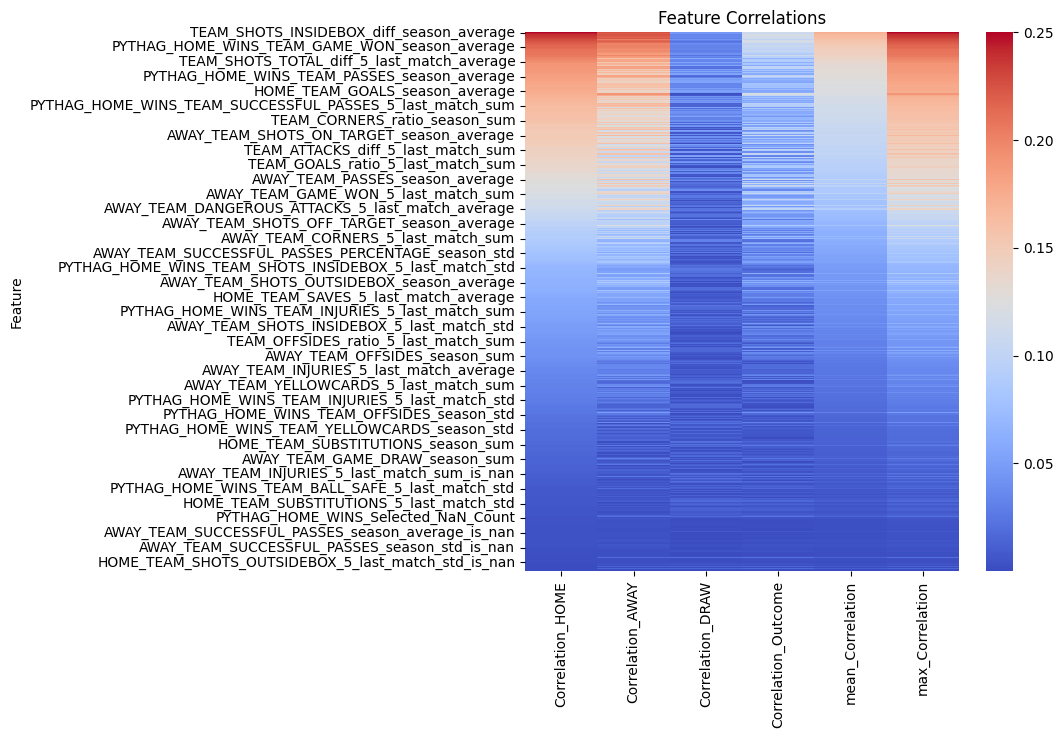

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = corr_data_team.set_index('Feature').dropna()
plt.figure(figsize=(7, 7))
sns.heatmap(heatmap_data, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

In [ ]:
len(corr_data_team[(corr_data_team['max_Correlation'] > 0.01)])

672

In [ ]:
print(len(corr_data_team[(corr_data_team['max_Correlation'] > 0.01)]))
print(train_team_data_fe.shape)
print(test_team_data_fe.shape)

selected_features = corr_data_team[(corr_data_team['max_Correlation'] > 0.01)]['Feature'].to_list()
train_team_data_fe = train_team_data_fe[selected_features]
test_team_data_fe = test_team_data_fe[selected_features]

print(train_team_data_fe.shape)
print(test_team_data_fe.shape)

775
(12303, 801)
(25368, 801)
(12303, 775)
(25368, 775)


## VIZ

In [ ]:
train_data_all = pd.concat([train_team_data_fe, train_scores['HOME_WINS']], axis=1)

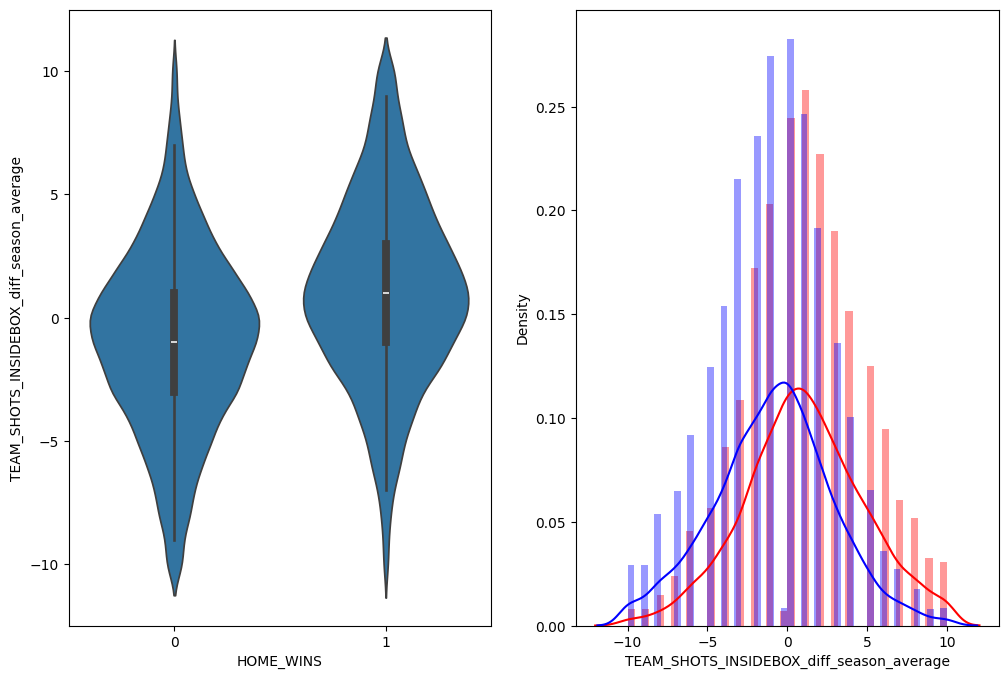

In [ ]:
plt.figure(figsize=(12, 8))
feat = "TEAM_SHOTS_INSIDEBOX_diff_season_average"
plt.subplot(1,2,1)
sns.violinplot(x = 'HOME_WINS', y = feat, data = train_data_all[0:])

plt.subplot(1,2,2)
sns.distplot(train_data_all[train_data_all['HOME_WINS'] == 1.0][feat][0:] , label = "1", color = 'red')
sns.distplot(train_data_all[train_data_all['HOME_WINS'] == 0.0][feat][0:] , label = "0" , color = 'blue' )
sns.distplot(train_data_all[train_data_all['HOME_WINS'] == 2.0][feat][0:] , label = "2" , color = 'yellow' )

plt.show()

In [ ]:
corr_data.Feature

0             TEAM_SHOTS_INSIDEBOX_diff_season_average
1                 TEAM_SHOTS_INSIDEBOX_diff_season_sum
2                    TEAM_GAME_WON_diff_season_average
3             TEAM_SHOTS_ON_TARGET_diff_season_average
4                        TEAM_GAME_WON_diff_season_sum
                            ...                       
800    PYTHAG_HOME_WINSTEAM_BALL_SAFE_5_last_match_std
801               AWAY_TEAM_BALL_SAFE_5_last_match_std
802                  HOME_fouls_to_yellow_ratio_season
803    PYTHAG_AWAY_WINSTEAM_BALL_SAFE_5_last_match_std
804                 HOME_TEAM_SUBSTITUTIONS_season_std
Name: Feature, Length: 805, dtype: object

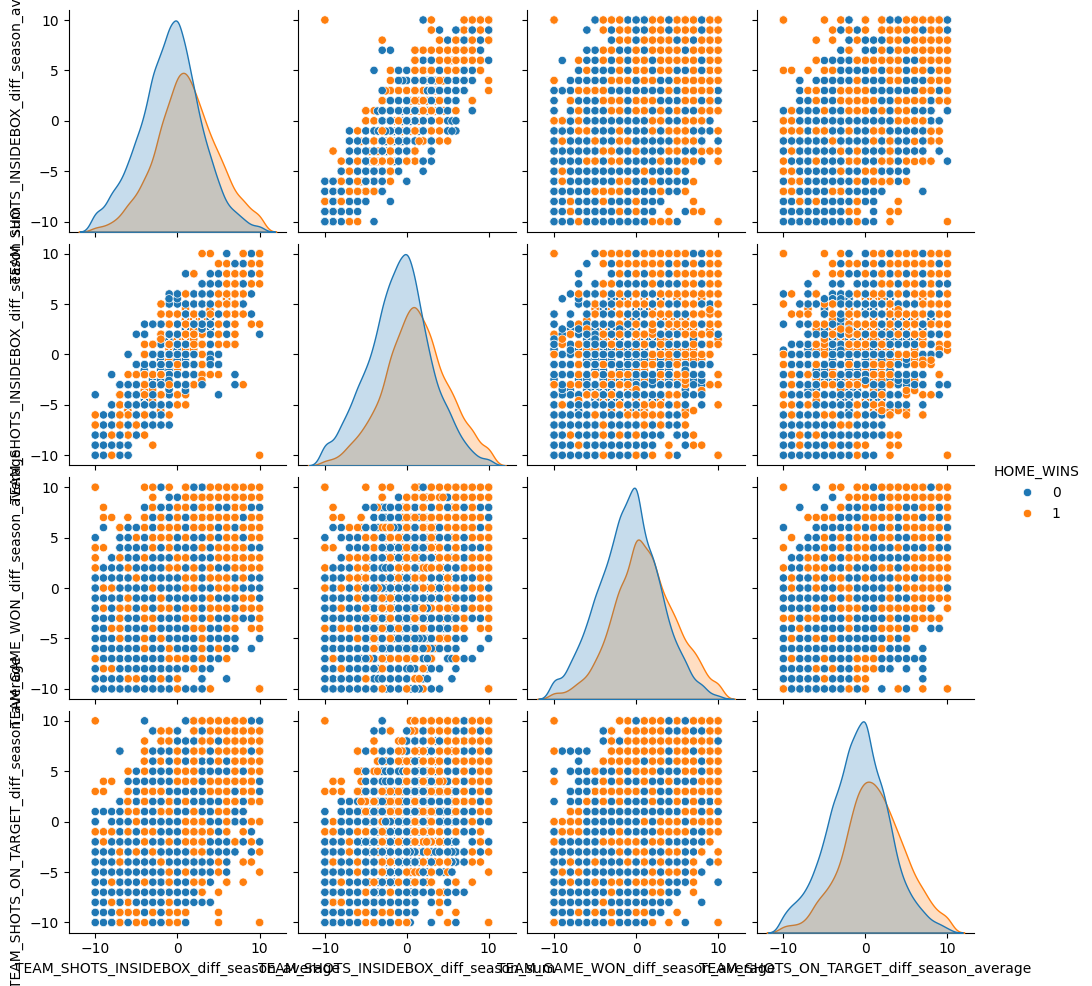

In [ ]:
n = train_data_all.shape[0]
sns.pairplot(train_data_all[['TEAM_SHOTS_INSIDEBOX_diff_season_average', 'TEAM_SHOTS_INSIDEBOX_diff_season_sum',
       'TEAM_GAME_WON_diff_season_average', 'TEAM_SHOTS_ON_TARGET_diff_season_average', 'HOME_WINS']][0:n], hue='HOME_WINS', vars=['TEAM_SHOTS_INSIDEBOX_diff_season_average', 'TEAM_SHOTS_INSIDEBOX_diff_season_sum',
       'TEAM_GAME_WON_diff_season_average', 'TEAM_SHOTS_ON_TARGET_diff_season_average'])
plt.show()

## FE Player Data

In [98]:
def count_positions(group):
    positions_count = {
        'midfielder': 0,
        'defender': 0,
        'goalkeeper': 0,
        'attacker': 0
    }
    for position in group['POSITION']:
        if position in positions_count:
            positions_count[position] += 1
    return pd.Series(positions_count)

def data_groupby(df):
  positions_counts = df.groupby('ID').apply(count_positions)
  positions_counts['players_count'] = positions_counts['midfielder'] + positions_counts['defender'] + positions_counts['goalkeeper'] + positions_counts['attacker']
  summed_metrics_per_id = df.drop(columns=['POSITION']).groupby('ID').sum()

  train_player_home_with_counts = summed_metrics_per_id.merge(positions_counts, on='ID', how='left')

  return train_player_home_with_counts

def add_missing_indicators(df, missing_threshold=0.01, consider_columns=None):
    if consider_columns is None:
        consider_columns = df.columns

    missing_stats = df[consider_columns].isna().mean()
    features_with_lots_of_nans = missing_stats[missing_stats > missing_threshold].index.tolist()
    print(features_with_lots_of_nans)
    for feature in features_with_lots_of_nans:
        indicator_feature_name = f"{feature}_is_nan"
        df[indicator_feature_name] = df[feature].isna().astype(int)
    return df

def process_dataframe(df):
    selected_features = df.columns[4:]
    df['Selected_NaN_Count'] = df[selected_features].isna().sum(axis=1)

    df_columns = df.iloc[:,4:].columns.to_list()
    for feat in df_columns:
        df[feat] = df.groupby(['TEAM_NAME', 'POSITION'])[feat].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x.mean()))

    df.iloc[:, 4:] = df.iloc[:, 4:].fillna(
        df.iloc[:, 4:].mean()
    )

    return df

In [118]:
train_home_player_statistics_df = pd.read_csv('Train_Data/train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv('Train_Data/train_away_player_statistics_df.csv', index_col=0)
test_home_player_statistics_df = pd.read_csv('Test_Data/test_home_player_statistics_df.csv', index_col=0)
test_away_player_statistics_df = pd.read_csv('Test_Data/test_away_player_statistics_df.csv', index_col=0)

In [119]:
train_home_player_statistics_df

LEAGUE TEAM_NAME    POSITION          PLAYER_NAME  \
ID                                                          
0      Ligue 1  Toulouse    defender        Agustín Rogel   
0      Ligue 1  Toulouse    defender    Mathieu Goncalves   
0      Ligue 1  Toulouse  goalkeeper      Baptiste Reynet   
0      Ligue 1  Toulouse  midfielder  Jean-Victor Makengo   
0      Ligue 1  Toulouse         NaN  Efthymios Koulouris   
...        ...       ...         ...                  ...   
12302  La Liga  Valencia  midfielder         Carlos Soler   
12302  La Liga  Valencia    attacker        Kévin Gameiro   
12302  La Liga  Valencia  midfielder     Francis Coquelin   
12302  La Liga  Valencia  goalkeeper       Jaume Doménech   
12302  La Liga  Valencia    attacker              Rodrigo   

       PLAYER_ACCURATE_CROSSES_season_sum  PLAYER_ACCURATE_PASSES_season_sum  \
ID                                                                             
0                                     0.0                                8.0   
0                                     0.0                                7.0   
0                                     0.0                               33.0   
0                                     8.0                               27.0   
0                                     2.0                               23.0   
...                                   ...                                ...   
12302                                 3.0                               17.0   
12302                                 0.0                               10.0   
12302                                 0.0                               50.0   
12302                                 0.0                                9.0   
12302                                15.0                               26.0   

       PLAYER_AERIALS_WON_season_sum  PLAYER_ASSISTS_season_sum  \
ID                                                                
0                                5.0                        0.0   
0                                4.0                        0.0   
0                                2.0                        0.0   
0                                2.0                        0.0   
0                               27.0                       14.0   
...                              ...                        ...   
12302                            3.0                        0.0   
12302                            1.0                       16.0   
12302                           10.0                        0.0   
12302                            0.0                        0.0   
12302                           10.0                      100.0   

       PLAYER_BIG_CHANCES_CREATED_season_sum  \
ID                                             
0                                        0.0   
0                                        0.0   
0                                        0.0   
0                                        8.0   
0                                        8.0   
...                                      ...   
12302                                    6.0   
12302                                   12.0   
12302                                    0.0   
12302                                    0.0   
12302                                   62.0   

       PLAYER_BIG_CHANCES_MISSED_season_sum  ...  \
ID                                           ...   
0                                       0.0  ...   
0                                       0.0  ...   
0                                       0.0  ...   
0                                       0.0  ...   
0                                      37.0  ...   
...                                     ...  ...   
12302                                   0.0  ...   
12302                                  14.0  ...   
12302                                   0.0  ...   
12302                                   0.0  ...   
12302                                  57.0  ...   


In [99]:

# train_home_player_statistics_df = add_missing_indicators(train_home_player_statistics_df, missing_threshold=0.2)
# train_home_player_statistics_df = process_dataframe(train_home_player_statistics_df)

# train_away_player_statistics_df = add_missing_indicators(train_away_player_statistics_df, missing_threshold=0.2)
# train_away_player_statistics_df = process_dataframe(train_away_player_statistics_df)

train_player_home = train_home_player_statistics_df.iloc[:,2:]
train_player_away = train_away_player_statistics_df.iloc[:,2:]

train_player_home = train_player_home.drop(columns=['PLAYER_NAME'])
train_player_away = train_player_away.drop(columns=['PLAYER_NAME'])

train_player_home = data_groupby(train_player_home)
train_player_away = data_groupby(train_player_away)

train_player_home.columns = 'HOME_' + train_player_home.columns
train_player_away.columns = 'AWAY_' + train_player_away.columns

# train_player_home = train_player_home.fillna(train_player_home.median())
# train_player_away = train_player_away.fillna(train_player_away.median())

train_player_data =  pd.concat([train_player_home,train_player_away],join='inner',axis=1)
train_player_data = train_player_data.replace({np.inf:np.nan,-np.inf:np.nan})

# test_player_home = add_missing_indicators(test_player_home, missing_threshold=0.2)
# test_player_away = add_missing_indicators(test_player_away, missing_threshold=0.2)

test_player_home = data_groupby(test_home_player_statistics_df)
test_player_away = data_groupby(test_away_player_statistics_df)

test_player_home.columns = 'HOME_' + test_player_home.columns
test_player_away.columns = 'AWAY_' + test_player_away.columns

# test_player_home = test_player_home.fillna(test_player_home.median())
# test_player_away = test_player_away.fillna(test_player_away.median())

test_player_data =  pd.concat([test_player_home,test_player_away],join='inner',axis=1)


In [90]:
train_home_player_statistics_df.iloc[:20]

LEAGUE TEAM_NAME    POSITION           PLAYER_NAME  \
ID                                                        
0   Ligue 1  Toulouse    defender         Agustín Rogel   
0   Ligue 1  Toulouse    defender     Mathieu Goncalves   
0   Ligue 1  Toulouse  goalkeeper       Baptiste Reynet   
0   Ligue 1  Toulouse  midfielder   Jean-Victor Makengo   
0   Ligue 1  Toulouse         NaN   Efthymios Koulouris   
0   Ligue 1  Toulouse  midfielder       Ibrahim Sangaré   
0   Ligue 1  Toulouse  midfielder       Mathieu Dossevi   
0   Ligue 1  Toulouse    defender  Nicolas Isimat-Mirin   
0   Ligue 1  Toulouse    defender         Issiaga Sylla   
0   Ligue 1  Toulouse         NaN      Aaron Leya Iseka   
0   Ligue 1  Toulouse         NaN           Yaya Sanogo   
0   Ligue 1  Toulouse  midfielder            Max Gradel   
0   Ligue 1  Toulouse    defender        Steven Moreira   
0   Ligue 1  Toulouse  goalkeeper      Mauro Goicoechea   
0   Ligue 1  Toulouse    defender          Kelvin Amian   
0   Ligue 1  Toulouse  midfielder      Quentin Boisgard   
0   Ligue 1  Toulouse  midfielder          Kouadio Koné   
0   Ligue 1  Toulouse         NaN           Wesley Saïd   
1   Ligue 2     Brest  goalkeeper    Gautier Larsonneur   
1   Ligue 2     Brest  midfielder       Ibrahima Diallo   

    PLAYER_ACCURATE_CROSSES_season_sum  PLAYER_ACCURATE_PASSES_season_sum  \
ID                                                                          
0                                  0.0                                8.0   
0                                  0.0                                7.0   
0                                  0.0                               33.0   
0                                  8.0                               27.0   
0                                  2.0                               23.0   
0                                  0.0                               44.0   
0                                100.0                               24.0   
0                                  0.0                               32.0   
0                                 14.0                               52.0   
0                                  0.0                                5.0   
0                                  0.0                                5.0   
0                                 34.0                               29.0   
0                                  8.0                               24.0   
0                                  0.0                                0.0   
0                                  2.0                               40.0   
0                                  5.0                               10.0   
0                                  0.0                                6.0   
0                                 11.0                               15.0   
1                                  0.0                               28.0   
1                                  3.0                                6.0   

    PLAYER_AERIALS_WON_season_sum  PLAYER_ASSISTS_season_sum  \
ID                                                             
0                             5.0                        0.0   
0                             4.0                        0.0   
0                             2.0                        0.0   
0                             2.0                        0.0   
0                            27.0                       14.0   
0                            26.0                       14.0   
0                             4.0                       14.0   
0                            46.0                        0.0   
0                            52.0                       14.0   
0                            10.0                        0.0   
0                            38.0                       14.0   
0                            15.0                       28.0   
0                             6.0                        0.0   
0                             0.0                  

In [100]:
correlated_HOME_WINS = top_correlated_features(train_player_data, train_scores, 'HOME_WINS')
correlated_AWAY_WINS = top_correlated_features(train_player_data, train_scores, 'AWAY_WINS')
correlated_DRAW = top_correlated_features(train_player_data, train_scores, 'DRAW')
correlated_Outcome = top_correlated_features(train_player_data, train_scores, 'Outcome')


correlated_HOME_WINS = correlated_HOME_WINS.rename(columns={'Correlation': 'Correlation_HOME'})
correlated_AWAY_WINS = correlated_AWAY_WINS.rename(columns={'Correlation': 'Correlation_AWAY'})
correlated_DRAW = correlated_DRAW.rename(columns={'Correlation': 'Correlation_DRAW'})
correlated_Outcome = correlated_Outcome.rename(columns={'Correlation': 'Correlation_Outcome'})

corr_home_away = correlated_HOME_WINS.merge(correlated_AWAY_WINS, on='Feature', how ='left')
corr_data = corr_home_away.merge(correlated_DRAW, on='Feature', how ='left')
corr_data_player = corr_data.merge(correlated_Outcome, on='Feature', how ='left')

corr_data_player

/var/folders/d7/x979bykd2dlfs7dc2t93ny0m0000gn/T/ipykernel_34053/2259318963.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(numeric_features_data[feature], target)


Feature  Correlation_HOME  \
0                         HOME_PLAYER_GOALS_season_sum          0.165766   
1                       HOME_PLAYER_ASSISTS_season_sum          0.154617   
2                     HOME_PLAYER_GOALS_season_average          0.151576   
3                   HOME_PLAYER_ASSISTS_season_average          0.129882   
4           HOME_PLAYER_BIG_CHANCES_CREATED_season_sum          0.127823   
..                                                 ...               ...   
609  AWAY_PLAYER_SHOTS_OFF_TARGET_5_last_match_average               NaN   
610               AWAY_PLAYER_CAPTAIN_5_last_match_std               NaN   
611            AWAY_PLAYER_LONG_BALLS_5_last_match_std               NaN   
612        AWAY_PLAYER_LONG_BALLS_WON_5_last_match_std               NaN   
613      AWAY_PLAYER_SHOTS_OFF_TARGET_5_last_match_std               NaN   

     Correlation_AWAY  Correlation_DRAW  Correlation_Outcome  
0            0.127432          0.053596             0.046974  
1            0.120129          0.048658             0.045373  
2            0.112427          0.053317             0.037919  
3            0.101290          0.040476             0.038579  
4            0.102309          0.037074             0.041192  
..                ...               ...                  ...  
609               NaN               NaN                  NaN  
610               NaN               NaN                  NaN  
611               NaN               NaN                  NaN  
612               NaN               NaN                  NaN  
613               NaN               NaN                  NaN  

[614 rows x 5 columns]

In [83]:
corr_data_player = corr_data_player.fillna(0)
corr_data_player['mean_Correlation'] = (corr_data_player['Correlation_HOME'] + corr_data_player['Correlation_AWAY'] + corr_data_player['Correlation_DRAW'])/3
corr_data_player['max_Correlation'] = corr_data_player[['Correlation_HOME', 'Correlation_AWAY', 'Correlation_DRAW']].max(axis=1)

corr_data_player.sort_values("max_Correlation", ascending=False).head(20)

Feature  Correlation_HOME  \
0                     HOME_PLAYER_GOALS_season_sum          0.165766   
1                   HOME_PLAYER_ASSISTS_season_sum          0.154617   
2                 HOME_PLAYER_GOALS_season_average          0.151576   
7                     AWAY_PLAYER_GOALS_season_sum          0.124854   
5                   AWAY_PLAYER_ASSISTS_season_sum          0.126560   
14                AWAY_PLAYER_GOALS_season_average          0.114507   
3               HOME_PLAYER_ASSISTS_season_average          0.129882   
4       HOME_PLAYER_BIG_CHANCES_CREATED_season_sum          0.127823   
12              AWAY_PLAYER_ASSISTS_season_average          0.116984   
6                   HOME_PLAYER_ASSISTS_season_std          0.124948   
8        HOME_PLAYER_BIG_CHANCES_MISSED_season_sum          0.124666   
9    HOME_PLAYER_BIG_CHANCES_MISSED_season_average          0.121380   
10              HOME_PLAYER_GOALS_5_last_match_sum          0.119746   
11          HOME_PLAYER_GOALS_5_last_match_average          0.118518   
22           AWAY_PLAYER_GOALS_CONCEDED_season_sum          0.105729   
25  AWAY_PLAYER_BIG_CHANCES_CREATED_season_average          0.102177   
13  HOME_PLAYER_BIG_CHANCES_CREATED_season_average          0.115958   
23                  AWAY_PLAYER_ASSISTS_season_std          0.103223   
36              AWAY_PLAYER_GOALS_5_last_match_sum          0.097370   
34          AWAY_PLAYER_GOALS_5_last_match_average          0.098091   

    Correlation_AWAY  Correlation_DRAW  Correlation_Outcome  mean_Correlation  \
0           0.127432          0.053596             0.046974          0.115598   
1           0.120129          0.048658             0.045373          0.107801   
2           0.112427          0.053317             0.037919          0.105773   
7           0.142967          0.009046             0.093106          0.092289   
5           0.141827          0.005916             0.090578          0.091434   
14          0.131506          0.008702             0.085865          0.084905   
3           0.101290          0.040476             0.038579          0.090549   
4           0.102309          0.037074             0.041192          0.089069   
12          0.125486          0.000431             0.076832          0.080967   
6           0.095604          0.040872             0.034854          0.087142   
8           0.092105          0.044233             0.030742          0.087001   
9           0.090230          0.042485             0.030611          0.084698   
10          0.088817          0.042122             0.029955          0.083561   
11          0.086790          0.042863             0.028277          0.082724   
22          0.116199          0.002540             0.072863          0.074823   
25          0.116046          0.006398             0.075022          0.074874   
13          0.080144          0.046956             0.021805          0.081019   
23          0.114592          0.003687             0.072546          0.073834   
36          0.114520          0.010235             0.076326          0.074042   
34          0.114362          0.009252             0.075654          0.073902   

    max_Correlation  
0          0.165766  
1          0.154617  
2          0.151576  
7          0.142967  
5          0.141827  
14         0.131506  
3          0.129882  
4          0.127823  
12         0.125486  
6          0.124948  
8          0.124666  
9          0.121380  
10         0.119746  
11         0.118518  
22         0.116199  
25         0.116046  
13         0.115958  
23         0.114592  
36         0.114520  
34         0.114362

In [84]:
corr_data_player['max_Correlation'].sum()

22.69336027670293

In [ ]:
corr_data_player['max_Correlation'].sum()

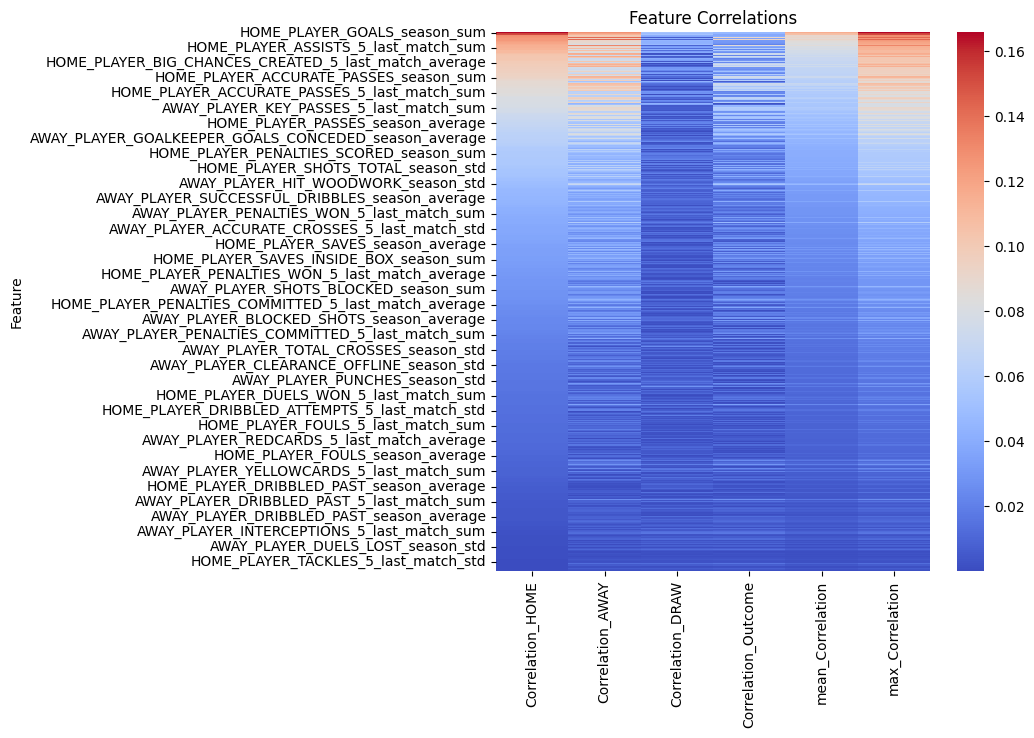

In [ ]:
heatmap_data = corr_data_player.set_index('Feature').dropna()
plt.figure(figsize=(7, 7))
sns.heatmap(heatmap_data, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

In [54]:
print(len(corr_data_player[(corr_data_player['max_Correlation'] > 0.00001)]))

570


In [55]:
print(train_player_data.shape)
print(test_player_data.shape)

selected_features = corr_data_player[(corr_data_player['max_Correlation'] > 0.00001)]['Feature'].to_list()
train_player_data = train_player_data[selected_features]
test_player_data = test_player_data[selected_features]

print(train_player_data.shape)
print(test_player_data.shape)

(12303, 614)
(25368, 614)
(12303, 570)
(25368, 570)


## Save FE data

In [56]:
train_data_to_modeling = pd.concat([train_team_data_fe, train_player_data], axis = 1)
test_data_to_modeling = pd.concat([test_team_data_fe, test_player_data], axis = 1)
train_scores['Outcome'] = train_scores.apply(combine_outcomes, axis=1)
train_new_y = train_scores['Outcome']
train_scores_supp['GOAL_DIFF_HOME_AWAY'] = pd.to_numeric(train_scores_supp['GOAL_DIFF_HOME_AWAY'], errors='coerce')

train_new_y_supp = train_scores_supp['GOAL_DIFF_HOME_AWAY']

# test_data_to_modeling.shape
train_data_to_modeling.to_csv('FE_Data/train_data_to_modeling.csv')
test_data_to_modeling.to_csv('FE_Data/test_data_to_modeling.csv')
train_new_y.to_csv('FE_Data/train_new_y.csv')



In [93]:
train_data_to_modeling = pd.read_csv('FE_Data/train_data_to_modeling.csv', index_col=0)
test_data_to_modeling = pd.read_csv('FE_Data/test_data_to_modeling.csv', index_col=0)
train_new_y = pd.read_csv('FE_Data/train_new_y.csv', index_col=0)


In [19]:
from sklearn.preprocessing import StandardScaler

X = train_data_to_modeling
y = train_new_y['Outcome']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.fit_transform(test_data_to_modeling)

# Convert back to DataFrame to retain column names for potential feature selection
train_data_to_modeling = pd.DataFrame(X_scaled, columns=X.columns)
test_data_to_modeling = pd.DataFrame(test_scaled, columns=test_data_to_modeling.columns)

train_data_to_modeling.head()

HOME_TEAM_SHOTS_TOTAL_season_sum  HOME_TEAM_SHOTS_INSIDEBOX_season_sum  \
0                         -0.486770                             -0.821120   
1                          0.569195                              1.352963   
2                         -0.134782                             -0.821120   
3                          0.921184                              0.265921   
4                         -0.486770                             -0.458773   

   HOME_TEAM_SHOTS_OFF_TARGET_season_sum  \
0                               0.174105   
1                              -0.538474   
2                               0.174105   
3                               0.174105   
4                              -0.894763   

   HOME_TEAM_SHOTS_ON_TARGET_season_sum  \
0                             -0.751800   
1                              0.646340   
2                             -0.751800   
3                              0.646340   
4                             -0.402265   

   HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum  HOME_TEAM_PASSES_season_sum  \
0                              -1.290702                    -0.843757   
1                               0.199073                     1.347506   
2                               1.316404                    -1.208967   
3                               0.571516                     1.712716   
4                              -0.173371                    -0.113336   

   HOME_TEAM_SUCCESSFUL_PASSES_season_sum  HOME_TEAM_SAVES_season_sum  \
0                               -0.774123                    0.109803   
1                                1.055593                    1.908129   
2                               -1.140066                   -0.969193   
3                                1.787479                   -0.969193   
4                               -0.408180                   -0.249863   

   HOME_TEAM_CORNERS_season_sum  HOME_TEAM_FOULS_season_sum  ...  \
0                     -0.537114                    0.317195  ...   
1                      0.533372                    1.044179  ...   
2                     -0.893943                    0.680687  ...   
3                     -0.893943                   -1.863756  ...   
4                     -0.180285                    0.680687  ...   

   HOME_PLAYER_TACKLES_5_last_match_std  AWAY_PLAYER_DRIBBLED_PAST_season_std  \
0                              0.423517                              0.550589   
1                             -0.715329                              0.349503   
2                              1.011308                              1.280619   
3                             -0.109169                             -0.065783   
4                              0.319429                              0.524361   

   AWAY_PLAYER_FOULS_season_std  \
0                     -0.421958   
1                     -0.274458   
2                      0.753827   
3                     -0.438815   
4                     -0.539958   

   AWAY_PLAYER_PENALTIES_MISSES_5_last_match_average  \
0                                          -0.396096   
1                                          -0.396096   
2                                          -0.396096   
3                                          -0.396096   
4                                           2.307644   

   AWAY_PLAYER_FOULS_5_last_match_average  HOME_PLAYER_REDCARDS_season_sum  \
0                                0.183202                        -0.968075   
1                                0.244686                        -0.968075   
2                                1.774971                         0.901854   
3                                0.798048                         0.278544   
4                               -0.137885                         0.278544   

   HOME_PLAYER_DUELS_LOST_season_average  \
0                               0.615603   
1                               0.401941   
2                               0.674360   
3                              -0.698417   
4    

# Modeling

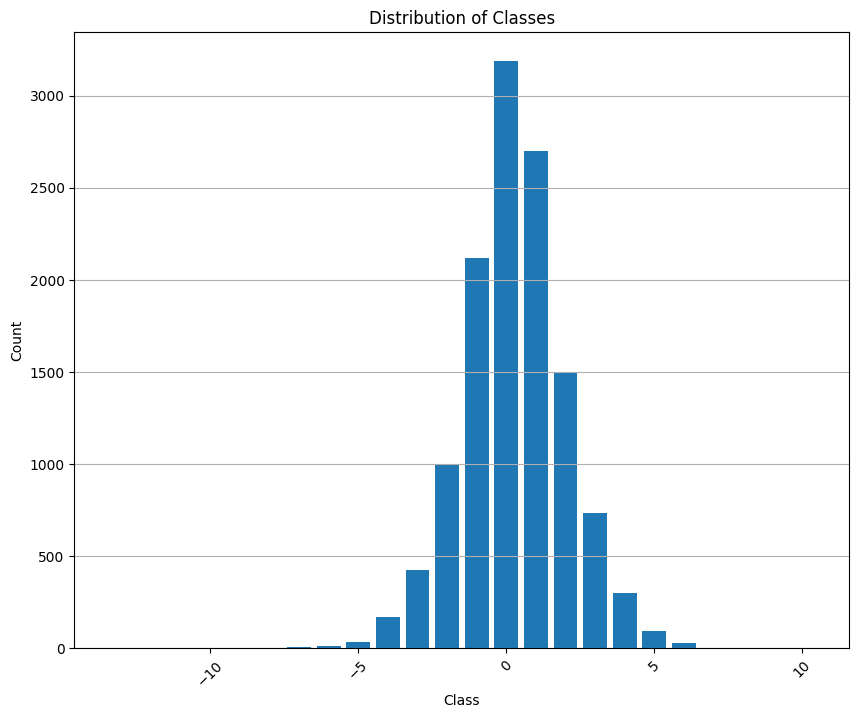

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'id' and 'target' columns

# Count the occurrence of each class
class_counts = train_scores_supp['GOAL_DIFF_HOME_AWAY'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')  # Adjust label as needed
plt.ylabel('Count')  # Adjust label as needed
plt.title('Distribution of Classes')  # Adjust title as needed
plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
plt.grid(axis='y')  # Adds a grid on y-axis for better readability

plt.show()


## LGBM Regressor

In [ ]:
#train_scores['Outcome'] = train_scores.apply(combine_outcomes, axis=1)
#train_new_y = train_scores['Outcome']
train_scores_supp['GOAL_DIFF_HOME_AWAY'] = pd.to_numeric(train_scores_supp['GOAL_DIFF_HOME_AWAY'], errors='coerce')

train_scores_supp['LogGD'] = np.sign(train_scores_supp['GOAL_DIFF_HOME_AWAY']) * np.log1p(np.abs(train_scores_supp['GOAL_DIFF_HOME_AWAY']))
train_new_y = train_scores_supp['LogGD']
train_new_y.fillna(0, inplace=True)
train_new_y


ID
0       -1.098612
1        0.000000
2       -0.693147
3        0.693147
4        0.000000
           ...   
12298   -0.693147
12299   -0.693147
12300   -0.693147
12301    1.386294
12302    1.098612
Name: LogGD, Length: 12303, dtype: float64

In [ ]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn import metrics, model_selection

def tune_lgbm_params(train_data_fe, train_new_y):
    def objective(trial):
        n_splits = 5
        cv_results = []

        # Use KFold for regression tasks
        kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)

        for train_index, valid_index in kf.split(train_data_fe):
            X_train, X_valid = train_data_fe.iloc[train_index], train_data_fe.iloc[valid_index]
            y_train, y_valid = train_new_y.iloc[train_index], train_new_y.iloc[valid_index]

            param = {
                'objective': 'regression',  # Adjusted for regression
                'boosting_type': 'goss',
                'verbosity': -1,
                'early_stopping_rounds': 200,
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
                'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
                'num_leaves': trial.suggest_int('num_leaves', 31, 5000),
                'max_depth': trial.suggest_int('max_depth', 3, 30),
                'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
            }

            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

            model = lgb.train(param, lgb_train, valid_sets=[lgb_eval])

            preds = model.predict(X_valid, num_iteration=model.best_iteration)

            # Use RMSE as the evaluation metric for regression
            rmse = np.sqrt(metrics.mean_squared_error(y_valid, preds))

            cv_results.append(rmse)

        avg_rmse = np.mean(cv_results)

        return avg_rmse

    study = optuna.create_study(direction='minimize')  # Minimize the RMSE for regression tasks
    study.optimize(objective, n_trials=100)  # Adjust the number of trials as necessary
    best_params_lgbm = study.best_trial.params

    print('Best trial:', best_params_lgbm)

    return best_params_lgbm


In [ ]:
best_params_lgbm = tune_lgbm_params(train_data_to_modeling, train_new_y)
print(best_params_lgbm)

[I 2024-03-09 20:26:11,980] A new study created in memory with name: no-name-822c7971-06d8-4abf-a722-746111003ff4
[I 2024-03-09 20:26:30,207] Trial 0 finished with value: 0.8086980660411088 and parameters: {'reg_lambda': 0.7200822565658834, 'n_estimators': 4129, 'num_leaves': 725, 'max_depth': 23, 'learning_rate': 0.2122898845089524, 'feature_fraction': 0.6482491929595906, 'min_gain_to_split': 4.2645659998569965, 'min_data_in_leaf': 75}. Best is trial 0 with value: 0.8086980660411088.
[I 2024-03-09 20:26:47,350] Trial 1 finished with value: 0.8029801599478195 and parameters: {'reg_lambda': 0.7438237420628734, 'n_estimators': 1653, 'num_leaves': 921, 'max_depth': 24, 'learning_rate': 0.06953479169205243, 'feature_fraction': 0.7922539714920727, 'min_gain_to_split': 3.4479124830073737, 'min_data_in_leaf': 96}. Best is trial 1 with value: 0.8029801599478195.
[I 2024-03-09 20:27:04,850] Trial 2 finished with value: 0.810401045882219 and parameters: {'reg_lambda': 0.761045362561583, 'n_estim

Best trial: {'reg_lambda': 0.14679369591209815, 'n_estimators': 4452, 'num_leaves': 4532, 'max_depth': 15, 'learning_rate': 0.011398310110437493, 'feature_fraction': 0.6435978552917814, 'min_gain_to_split': 7.126270303406885, 'min_data_in_leaf': 69}
{'reg_lambda': 0.14679369591209815, 'n_estimators': 4452, 'num_leaves': 4532, 'max_depth': 15, 'learning_rate': 0.011398310110437493, 'feature_fraction': 0.6435978552917814, 'min_gain_to_split': 7.126270303406885, 'min_data_in_leaf': 69}


In [ ]:
def test_predict(train, test, y, best_params_lgbm):
    best_params_lgbm['boosting_type'] = 'goss'
    best_params_lgbm['objective'] = 'regression'
    best_params_lgbm['verbosity'] = -1

    lgb_full_train = lgb.Dataset(train, y)

    final_model = lgb.train(best_params_lgbm, lgb_full_train)

    test_predictions = final_model.predict(test)

    return test_predictions


In [ ]:
predictions = test_predict(train_data_to_modeling, test_data_to_modeling, train_new_y, best_params_lgbm)
predictions

array([-0.33068641, -0.31007451,  0.5641664 , ...,  0.6662425 ,
        0.27054289,  0.32023039])

In [ ]:
def classify_predictions(predictions):
    # Define your thresholds based on your analysis
    draw_lower_threshold = -0.05
    draw_upper_threshold = 0.2

    classifications = []
    for prediction in predictions:
        if draw_lower_threshold <= prediction <= draw_upper_threshold:
            classifications.append(0)
        elif prediction > draw_upper_threshold:
            classifications.append(1)
        else:  # prediction < draw_lower_threshold
            classifications.append(2)
    return classifications

classifications = classify_predictions(predictions)


In [ ]:
classifications_df = pd.DataFrame(classifications, columns=["Outcome"])
print(classifications_df["Outcome"].value_counts()/len(classifications_df["Outcome"]))

1    0.419387
2    0.314491
0    0.266123
Name: Outcome, dtype: float64


In [ ]:
print(train_scores["Outcome"].value_counts()/len(train_scores["Outcome"]))

1    0.435341
2    0.305698
0    0.258961
Name: Outcome, dtype: float64


In [ ]:
import pandas as pd
import numpy as np

def generate_predictions(test, classifications):
    # Initialize the submission DataFrame with zeros and appropriate columns
    submission_df = pd.DataFrame(0, index=np.arange(len(classifications)), columns=['HOME_WINS', 'DRAW', 'AWAY_WINS'])

    # Assign 1 to the appropriate column based on the classification
    for i, classification in enumerate(classifications):
        if classification == 1:
            submission_df.loc[i, 'HOME_WINS'] = 1
        elif classification == 0:
            submission_df.loc[i, 'DRAW'] = 1
        elif classification == 2:
            submission_df.loc[i, 'AWAY_WINS'] = 1

    submission_df.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
    submission_df.index = test_home.index
    submission_df = submission_df.reset_index()
    submission_df.columns = ['ID', 'HOME_WINS', 'DRAW', 'AWAY_WINS']

    return submission_df


submission_df = generate_predictions(test_data_to_modeling, classifications)
submission_df

ID  HOME_WINS  DRAW  AWAY_WINS
0      12303          0     0          1
1      12304          0     0          1
2      12305          1     0          0
3      12306          0     0          1
4      12307          0     0          1
...      ...        ...   ...        ...
25363  37666          0     1          0
25364  37667          0     1          0
25365  37668          1     0          0
25366  37669          1     0          0
25367  37670          1     0          0

[25368 rows x 4 columns]

In [ ]:
submission_df['HOME_WINS'] = 0
submission_df['DRAW'] = 1
submission_df['AWAY_WINS'] = 0
submission_df

ID  HOME_WINS  DRAW  AWAY_WINS
0      12303          0     1          0
1      12304          0     1          0
2      12305          0     1          0
3      12306          0     1          0
4      12307          0     1          0
...      ...        ...   ...        ...
25363  37666          0     1          0
25364  37667          0     1          0
25365  37668          0     1          0
25366  37669          0     1          0
25367  37670          0     1          0

[25368 rows x 4 columns]

In [ ]:
submission_df.to_csv('drive/MyDrive/QRT/Train_Data/submission_regression.csv', index=False)

In [ ]:
HOME_WINS: 0,43716493219804475
DRAW: 0,27
AWAY_WINS: 0,29


## Catboost

In [10]:
import optuna
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, model_selection

def tune_knn_params(train_data_fe, train_new_y):

    def objective(trial):
        n_splits = 3
        cv_results = []

        kf = model_selection.RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=2, random_state=42)

        for train_index, valid_index in kf.split(train_data_fe, train_new_y):
            X_train, X_valid = train_data_fe.iloc[train_index], train_data_fe.iloc[valid_index]
            y_train, y_valid = train_new_y.iloc[train_index], train_new_y.iloc[valid_index]

            param = {
                'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
                'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
                'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
                'leaf_size': trial.suggest_int('leaf_size', 10, 100),
                'p': trial.suggest_categorical('p', [1, 2]),  # 1 for Manhattan, 2 for Euclidean distance
            }

            model = KNeighborsClassifier(**param)
            model.fit(X_train, y_train)
            preds = model.predict(X_valid)
            acc = metrics.accuracy_score(y_valid, preds)

            cv_results.append(acc)

        avg_acc = np.mean(cv_results)
        return avg_acc

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    best_params_knn = study.best_trial.params

    print('Best trial:', study.best_trial.params)

    return best_params_knn


In [11]:
best_params_knn = tune_knn_params(train_data_to_modeling, train_new_y)
print(best_params_knn)

[I 2024-03-16 12:53:31,000] A new study created in memory with name: no-name-6d45d685-c994-4fff-bcd8-765fba3c8324
/opt/anaconda3/envs/um6p/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/um6p/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(
/opt/anaconda3/envs/um6p/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/um6p/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed wh

Best trial: {'n_neighbors': 26, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 40, 'p': 1}
{'n_neighbors': 26, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 40, 'p': 1}


In [12]:
from sklearn.neighbors import KNeighborsClassifier

def test_predict_knn(train, test, y, best_params_knn):
    # Create a KNN classifier with the provided best parameters
    model = KNeighborsClassifier(**best_params_knn)
    
    # Fit the model on the training data
    model.fit(train, y)
    
    # Predict on the test data
    test_predictions = model.predict(test)
    
    return test_predictions


In [13]:
predictions = test_predict_knn(train_data_to_modeling, test_data_to_modeling, train_new_y, best_params_knn)

/opt/anaconda3/envs/um6p/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## LGBM

In [50]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score
import optuna

def objective(trial):
    # Hyperparameters to be tuned
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 3,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'early_stopping_rounds':200,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
    }
    
    # GroupKFold cross-validation
    kf = GroupKFold(n_splits=5)
    accuracies = []
    for train_index, valid_index in kf.split(X, y, groups):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
        
        model = lgb.train(params, train_data, valid_sets=[valid_data])
        y_pred = np.argmax(model.predict(X_valid, num_iteration=model.best_iteration), axis=1)
        accuracy = accuracy_score(y_valid, y_pred)
        accuracies.append(accuracy)
    
    return np.mean(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f'Best trial: {study.best_trial.params}')


[I 2024-03-23 16:32:27,756] A new study created in memory with name: no-name-7e13b81a-7c0c-42f6-a0ae-ac9b2ef90c2a
[I 2024-03-23 16:32:28,659] Trial 0 finished with value: 0.893 and parameters: {'lambda_l1': 6.205230716117367e-05, 'lambda_l2': 0.0016470418222543667, 'num_leaves': 45, 'feature_fraction': 0.800071336792645, 'bagging_fraction': 0.5316943131320492, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 12}. Best is trial 0 with value: 0.893.
[I 2024-03-23 16:32:30,898] Trial 1 finished with value: 0.9099999999999999 and parameters: {'lambda_l1': 0.000344698723517927, 'lambda_l2': 0.0005746502364064117, 'num_leaves': 99, 'feature_fraction': 0.6866943739560136, 'bagging_fraction': 0.994937917022524, 'bagging_freq': 4, 'min_child_samples': 17, 'max_depth': 0}. Best is trial 1 with value: 0.9099999999999999.
[I 2024-03-23 16:32:31,337] Trial 2 finished with value: 0.8930000000000001 and parameters: {'lambda_l1': 3.246100981262029e-07, 'lambda_l2': 0.0018594165515856593, 'num_

Best trial: {'lambda_l1': 0.0012528501117552982, 'lambda_l2': 0.00015660453989075764, 'num_leaves': 24, 'feature_fraction': 0.860921097618455, 'bagging_fraction': 0.7722212686387235, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 6}


In [121]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn import metrics, model_selection

def tune_lgbm_params(train_data_fe, train_new_y):

  def objective(trial):
      n_splits = 5
      cv_results = []
      
      # kf = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

      # for train_index, valid_index in kf.split(train_data_fe, train_new_y):
      #     X_train, X_valid = train_data_fe.iloc[train_index], train_data_fe.iloc[valid_index]
      #     y_train, y_valid = train_new_y.iloc[train_index], train_new_y.iloc[valid_index]
      
      kf = model_selection.GroupKFold(n_splits=5)

      for train_index, valid_index in kf.split(train_data_fe, train_new_y, groups=groups):
          X_train, X_valid = train_data_fe.iloc[train_index], train_data_fe.iloc[valid_index]
          y_train, y_valid = train_new_y.iloc[train_index], train_new_y.iloc[valid_index]


          param = {
              'objective': 'multiclass',
              'boosting_type':'gbdt',
              # 'metric': 'multi_logloss',
              'num_class': 3,
              'verbosity': -1,
              # 'num_threads': -1,
              'early_stopping_rounds':300,
              'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
              'n_estimators': trial.suggest_int('n_estimators', 2000, 5000),
              'num_leaves': trial.suggest_int('num_leaves', 200, 5000),
              'max_depth': trial.suggest_int('max_depth', 3, 30),
              'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
              'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
              # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
              # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
              'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 100),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 300),
          }

          lgb_train = lgb.Dataset(X_train, y_train)
          lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

          model = lgb.train(param, lgb_train, valid_sets=[lgb_eval])
          # model = lgb.train(param, lgb_train, valid_sets=[lgb_eval], early_stopping_rounds=200)


          preds = model.predict(X_valid, num_iteration=model.best_iteration)
          # preds = np.argmax(preds, axis=1)
          preds_acc = np.argmax(preds, axis=1)
          # conf_matrix = metrics.confusion_matrix(
          #                     y_valid, preds, sample_weight=None,
          #                     normalize=None
          #                     )
          # print(conf_matrix)
        #   acc = metrics.accuracy_score(y_valid, preds)
          acc = metrics.log_loss(y_valid, preds)
          print(metrics.accuracy_score(y_valid, preds_acc))
          cv_results.append(acc)

      avg_acc = np.mean(cv_results)

      return avg_acc

  study = optuna.create_study(direction='minimize')
  study.optimize(objective, n_trials=100)
  best_params_lgbm = study.best_trial.params

  print('Best trial:', study.best_trial.params)

  return best_params_lgbm


In [122]:
best_params_lgbm = tune_lgbm_params(train_data_to_modeling, train_new_y)
print(best_params_lgbm)

[I 2024-03-24 00:39:44,310] A new study created in memory with name: no-name-607d3f75-5933-4d3e-b4ea-fdceb639bb2a


0.5264012997562957
0.49167005282405524
0.466260162601626
0.474390243902439


[I 2024-03-24 00:40:05,654] Trial 0 finished with value: 1.0354007689627494 and parameters: {'reg_lambda': 0.4921888919672187, 'n_estimators': 2749, 'num_leaves': 1497, 'max_depth': 18, 'learning_rate': 0.2685938529413281, 'feature_fraction': 0.737666112294405, 'min_gain_to_split': 69.30946166169143, 'min_data_in_leaf': 168}. Best is trial 0 with value: 1.0354007689627494.


0.4686991869918699
0.5243704305442729
0.4900446972775295
0.4634146341463415
0.4715447154471545


[I 2024-03-24 00:40:32,137] Trial 1 finished with value: 1.0377042650238384 and parameters: {'reg_lambda': 0.6899924516931207, 'n_estimators': 3461, 'num_leaves': 1580, 'max_depth': 27, 'learning_rate': 0.006435253909354185, 'feature_fraction': 0.7228312863545007, 'min_gain_to_split': 68.75136857903725, 'min_data_in_leaf': 115}. Best is trial 0 with value: 1.0354007689627494.


0.4682926829268293
0.5182778229082047
0.4973587972368956
0.47520325203252034
0.4772357723577236


[I 2024-03-24 00:41:01,250] Trial 2 finished with value: 1.0244175684256926 and parameters: {'reg_lambda': 0.8769201988494539, 'n_estimators': 2181, 'num_leaves': 4039, 'max_depth': 18, 'learning_rate': 0.25234938293093784, 'feature_fraction': 0.8286089140989141, 'min_gain_to_split': 3.6665036151095842, 'min_data_in_leaf': 143}. Best is trial 2 with value: 1.0244175684256926.


0.4695121951219512
0.529650690495532
0.4912637139374238
0.46178861788617886
0.47276422764227644


[I 2024-03-24 00:41:23,680] Trial 3 finished with value: 1.0403432148700469 and parameters: {'reg_lambda': 0.8641760629256002, 'n_estimators': 4012, 'num_leaves': 1788, 'max_depth': 16, 'learning_rate': 0.16028728460695454, 'feature_fraction': 0.9801116076731915, 'min_gain_to_split': 86.76447448770729, 'min_data_in_leaf': 72}. Best is trial 2 with value: 1.0244175684256926.


0.46422764227642277
0.5280259951259139
0.49085737505079235
0.45934959349593496
0.4719512195121951


[I 2024-03-24 00:41:42,699] Trial 4 finished with value: 1.0364217250853605 and parameters: {'reg_lambda': 0.8861609413602262, 'n_estimators': 4612, 'num_leaves': 1801, 'max_depth': 11, 'learning_rate': 0.19697255458956042, 'feature_fraction': 0.6124468942208784, 'min_gain_to_split': 72.39675742922317, 'min_data_in_leaf': 290}. Best is trial 2 with value: 1.0244175684256926.


0.4605691056910569
0.5357432981316004
0.49167005282405524
0.47520325203252034
0.4715447154471545


[I 2024-03-24 00:42:07,813] Trial 5 finished with value: 1.0295860093038287 and parameters: {'reg_lambda': 0.9277245901081311, 'n_estimators': 2860, 'num_leaves': 2366, 'max_depth': 23, 'learning_rate': 0.03262934417664507, 'feature_fraction': 0.8799610469562364, 'min_gain_to_split': 40.60727331213828, 'min_data_in_leaf': 208}. Best is trial 2 with value: 1.0244175684256926.


0.47073170731707314
0.5247766043866775
0.48923201950426654
0.4634146341463415
0.4739837398373984


[I 2024-03-24 00:42:25,006] Trial 6 finished with value: 1.0387697158133233 and parameters: {'reg_lambda': 0.8680918709781967, 'n_estimators': 2132, 'num_leaves': 4162, 'max_depth': 9, 'learning_rate': 0.2607304814485413, 'feature_fraction': 0.6924671898841368, 'min_gain_to_split': 82.65782428550878, 'min_data_in_leaf': 46}. Best is trial 2 with value: 1.0244175684256926.


0.4666666666666667
0.5353371242891958
0.49573344169036976
0.4772357723577236
0.47317073170731705


[I 2024-03-24 00:42:57,031] Trial 7 finished with value: 1.0258321021555048 and parameters: {'reg_lambda': 0.5786567733715571, 'n_estimators': 2113, 'num_leaves': 4815, 'max_depth': 22, 'learning_rate': 0.1616219483234998, 'feature_fraction': 0.7881149544468226, 'min_gain_to_split': 29.676025659413362, 'min_data_in_leaf': 220}. Best is trial 2 with value: 1.0244175684256926.


0.474390243902439
0.5329000812347685
0.5006095083299472
0.48252032520325205
0.4796747967479675


[I 2024-03-24 00:43:20,157] Trial 8 finished with value: 1.0155866329633358 and parameters: {'reg_lambda': 0.8987574690976925, 'n_estimators': 4597, 'num_leaves': 2587, 'max_depth': 19, 'learning_rate': 0.06070266549539606, 'feature_fraction': 0.5636783123144193, 'min_gain_to_split': 5.0334421284748405, 'min_data_in_leaf': 277}. Best is trial 8 with value: 1.0155866329633358.


0.48089430894308943
0.5345247766043867
0.49207639171068673
0.4841463414634146
0.47764227642276424


[I 2024-03-24 00:43:49,361] Trial 9 finished with value: 1.0175462921180842 and parameters: {'reg_lambda': 0.030222629704005244, 'n_estimators': 3204, 'num_leaves': 4367, 'max_depth': 23, 'learning_rate': 0.09105785551320099, 'feature_fraction': 0.7891411731013434, 'min_gain_to_split': 5.789901635321848, 'min_data_in_leaf': 40}. Best is trial 8 with value: 1.0155866329633358.


0.4792682926829268
0.5357432981316004
0.4953271028037383
0.4788617886178862
0.4735772357723577


[I 2024-03-24 00:44:02,410] Trial 10 finished with value: 1.0242075124303611 and parameters: {'reg_lambda': 0.2989890593075768, 'n_estimators': 4939, 'num_leaves': 664, 'max_depth': 3, 'learning_rate': 0.08176983259864294, 'feature_fraction': 0.5066460404807688, 'min_gain_to_split': 24.19003477459516, 'min_data_in_leaf': 284}. Best is trial 8 with value: 1.0155866329633358.


0.47479674796747967
0.5316815597075548
0.49939049167005284
0.47804878048780486
0.4768292682926829


[I 2024-03-24 00:44:26,650] Trial 11 finished with value: 1.0185956196772619 and parameters: {'reg_lambda': 0.06429037660470188, 'n_estimators': 3908, 'num_leaves': 3432, 'max_depth': 30, 'learning_rate': 0.0891558634671799, 'feature_fraction': 0.5976705911194432, 'min_gain_to_split': 5.018759011681664, 'min_data_in_leaf': 10}. Best is trial 8 with value: 1.0155866329633358.


0.4764227642276423
0.5329000812347685
0.49329540837058106
0.4768292682926829
0.47520325203252034


[I 2024-03-24 00:44:48,254] Trial 12 finished with value: 1.0220672093450898 and parameters: {'reg_lambda': 0.06571857940893303, 'n_estimators': 3433, 'num_leaves': 2874, 'max_depth': 23, 'learning_rate': 0.08907433983525988, 'feature_fraction': 0.5037718162637874, 'min_gain_to_split': 18.66857872194935, 'min_data_in_leaf': 91}. Best is trial 8 with value: 1.0155866329633358.


0.4813008130081301
0.5292445166531276
0.4912637139374238
0.4715447154471545
0.47479674796747967


[I 2024-03-24 00:45:11,523] Trial 13 finished with value: 1.0312232071955356 and parameters: {'reg_lambda': 0.3021240970607811, 'n_estimators': 4303, 'num_leaves': 3379, 'max_depth': 14, 'learning_rate': 0.05849095914102219, 'feature_fraction': 0.6311748267322711, 'min_gain_to_split': 47.527947878081704, 'min_data_in_leaf': 234}. Best is trial 8 with value: 1.0155866329633358.


0.47235772357723577
0.5060926076360682
0.4656643640796424
0.43821138211382116
0.4638211382113821


[I 2024-03-24 00:46:22,391] Trial 14 finished with value: 1.0547802124092935 and parameters: {'reg_lambda': 0.2822952466231684, 'n_estimators': 2966, 'num_leaves': 4841, 'max_depth': 26, 'learning_rate': 0.11628609609348985, 'feature_fraction': 0.8937341459865802, 'min_gain_to_split': 0.3595210064637362, 'min_data_in_leaf': 5}. Best is trial 8 with value: 1.0155866329633358.


0.4479674796747967
0.5308692120227457
0.4973587972368956
0.4760162601626016
0.4796747967479675


[I 2024-03-24 00:46:44,777] Trial 15 finished with value: 1.0207532225183757 and parameters: {'reg_lambda': 0.6925774738689053, 'n_estimators': 3721, 'num_leaves': 2668, 'max_depth': 20, 'learning_rate': 0.12341476686190034, 'feature_fraction': 0.6641972950558764, 'min_gain_to_split': 15.035796710032855, 'min_data_in_leaf': 177}. Best is trial 8 with value: 1.0155866329633358.


0.4764227642276423
0.5341186027619821
0.4904510361641609
0.4788617886178862
0.47276422764227644


[I 2024-03-24 00:47:10,749] Trial 16 finished with value: 1.0276520772209543 and parameters: {'reg_lambda': 0.476670031338268, 'n_estimators': 4394, 'num_leaves': 3885, 'max_depth': 12, 'learning_rate': 0.04442696229929094, 'feature_fraction': 0.5548239391217764, 'min_gain_to_split': 34.27471181030838, 'min_data_in_leaf': 131}. Best is trial 8 with value: 1.0155866329633358.


0.47479674796747967
0.5300568643379366
0.4937017472572125
0.46747967479674796
0.47032520325203253


[I 2024-03-24 00:47:26,371] Trial 17 finished with value: 1.0323470054646684 and parameters: {'reg_lambda': 0.16190397796395928, 'n_estimators': 3172, 'num_leaves': 286, 'max_depth': 26, 'learning_rate': 0.2038856535867117, 'feature_fraction': 0.7805626831732433, 'min_gain_to_split': 54.19148123927598, 'min_data_in_leaf': 246}. Best is trial 8 with value: 1.0155866329633358.


0.4739837398373984
0.529650690495532
0.497765136123527
0.4772357723577236
0.47804878048780486


[I 2024-03-24 00:48:22,297] Trial 18 finished with value: 1.0194620091370807 and parameters: {'reg_lambda': 0.7135078046817748, 'n_estimators': 2509, 'num_leaves': 3222, 'max_depth': 6, 'learning_rate': 0.0038178487434059882, 'feature_fraction': 0.9960160823584968, 'min_gain_to_split': 12.192576596087637, 'min_data_in_leaf': 44}. Best is trial 8 with value: 1.0155866329633358.


0.4739837398373984
0.5276198212835094
0.49329540837058106
0.4711382113821138
0.47317073170731705


[I 2024-03-24 00:48:45,815] Trial 19 finished with value: 1.0325636383153487 and parameters: {'reg_lambda': 0.3915744962405, 'n_estimators': 4722, 'num_leaves': 2309, 'max_depth': 30, 'learning_rate': 0.06380750434470606, 'feature_fraction': 0.8532008294389422, 'min_gain_to_split': 52.13249462739258, 'min_data_in_leaf': 181}. Best is trial 8 with value: 1.0155866329633358.


0.4719512195121951
0.5280259951259139
0.4949207639171069
0.4772357723577236
0.48008130081300815


[I 2024-03-24 00:49:02,924] Trial 20 finished with value: 1.0189810177882115 and parameters: {'reg_lambda': 0.9952218193627922, 'n_estimators': 3230, 'num_leaves': 1023, 'max_depth': 21, 'learning_rate': 0.12504183266371935, 'feature_fraction': 0.5728136265793539, 'min_gain_to_split': 10.995799446409059, 'min_data_in_leaf': 261}. Best is trial 8 with value: 1.0155866329633358.


0.474390243902439
0.5089358245329001
0.4766355140186916
0.45447154471544715
0.45975609756097563


[I 2024-03-24 00:50:01,584] Trial 21 finished with value: 1.0425631089265075 and parameters: {'reg_lambda': 0.02460355079740282, 'n_estimators': 3882, 'num_leaves': 3475, 'max_depth': 29, 'learning_rate': 0.08996767853582706, 'feature_fraction': 0.5643397495501681, 'min_gain_to_split': 0.3786535346710602, 'min_data_in_leaf': 9}. Best is trial 8 with value: 1.0155866329633358.


0.4548780487804878
0.5320877335499594
0.49207639171068673
0.47479674796747967
0.4760162601626016


[I 2024-03-24 00:50:28,517] Trial 22 finished with value: 1.023359772357685 and parameters: {'reg_lambda': 0.1368245542760032, 'n_estimators': 4072, 'num_leaves': 4312, 'max_depth': 25, 'learning_rate': 0.10312184115219317, 'feature_fraction': 0.6284738059002928, 'min_gain_to_split': 22.52150619061132, 'min_data_in_leaf': 37}. Best is trial 8 with value: 1.0155866329633358.


0.4739837398373984
0.5272136474411048
0.4937017472572125
0.47764227642276424
0.4760162601626016


[I 2024-03-24 00:50:56,262] Trial 23 finished with value: 1.0177316396611686 and parameters: {'reg_lambda': 0.12405536681456418, 'n_estimators': 4321, 'num_leaves': 3681, 'max_depth': 28, 'learning_rate': 0.028883086252232792, 'feature_fraction': 0.6803884079736218, 'min_gain_to_split': 8.930121482928637, 'min_data_in_leaf': 82}. Best is trial 8 with value: 1.0155866329633358.


0.4792682926829268
0.5284321689683185
0.49451442503047544
0.4796747967479675
0.4760162601626016


[I 2024-03-24 00:51:28,201] Trial 24 finished with value: 1.0184762557489195 and parameters: {'reg_lambda': 0.19205698350102818, 'n_estimators': 4338, 'num_leaves': 4464, 'max_depth': 24, 'learning_rate': 0.026203719833717082, 'feature_fraction': 0.6814393543393895, 'min_gain_to_split': 10.350742426193822, 'min_data_in_leaf': 85}. Best is trial 8 with value: 1.0155866329633358.


0.47560975609756095
0.5231519090170593
0.48720032507110933
0.45365853658536587
0.4682926829268293


[I 2024-03-24 00:51:54,632] Trial 25 finished with value: 1.044434056482065 and parameters: {'reg_lambda': 0.008652824593393116, 'n_estimators': 4721, 'num_leaves': 3858, 'max_depth': 20, 'learning_rate': 0.05963139476084525, 'feature_fraction': 0.78743248493133, 'min_gain_to_split': 98.8923172510845, 'min_data_in_leaf': 118}. Best is trial 8 with value: 1.0155866329633358.


0.45
0.5292445166531276
0.4953271028037383
0.47479674796747967
0.4760162601626016


[I 2024-03-24 00:52:16,667] Trial 26 finished with value: 1.025489543060915 and parameters: {'reg_lambda': 0.240333537066733, 'n_estimators': 4498, 'num_leaves': 3031, 'max_depth': 28, 'learning_rate': 0.29826145974603036, 'feature_fraction': 0.7180636575659399, 'min_gain_to_split': 28.480812532984693, 'min_data_in_leaf': 68}. Best is trial 8 with value: 1.0155866329633358.


0.47235772357723577
0.5385865150284321
0.4928890694839496
0.47560975609756095
0.4715447154471545


[I 2024-03-24 00:52:46,263] Trial 27 finished with value: 1.0283955873296409 and parameters: {'reg_lambda': 0.36666744986452565, 'n_estimators': 3675, 'num_leaves': 3704, 'max_depth': 16, 'learning_rate': 0.02578137690361571, 'feature_fraction': 0.9351099756862169, 'min_gain_to_split': 36.8822633807946, 'min_data_in_leaf': 103}. Best is trial 8 with value: 1.0155866329633358.


0.47317073170731705
0.5300568643379366
0.4961397805770012
0.47520325203252034
0.4760162601626016


[I 2024-03-24 00:53:14,986] Trial 28 finished with value: 1.021583677947047 and parameters: {'reg_lambda': 0.5886950972544778, 'n_estimators': 4959, 'num_leaves': 4585, 'max_depth': 18, 'learning_rate': 0.13541961117064524, 'feature_fraction': 0.6589844225031585, 'min_gain_to_split': 17.943580059700714, 'min_data_in_leaf': 32}. Best is trial 8 with value: 1.0155866329633358.


0.47479674796747967
0.528838342810723
0.497765136123527
0.4788617886178862
0.47520325203252034


[I 2024-03-24 00:53:37,961] Trial 29 finished with value: 1.016744155780006 and parameters: {'reg_lambda': 0.11741502801351233, 'n_estimators': 4175, 'num_leaves': 2203, 'max_depth': 19, 'learning_rate': 0.06771927816602763, 'feature_fraction': 0.7419112257345476, 'min_gain_to_split': 8.108137765516403, 'min_data_in_leaf': 150}. Best is trial 8 with value: 1.0155866329633358.


0.47560975609756095
0.5308692120227457
0.49167005282405524
0.4735772357723577
0.4719512195121951


[I 2024-03-24 00:53:59,952] Trial 30 finished with value: 1.030299257556242 and parameters: {'reg_lambda': 0.7832052408146853, 'n_estimators': 2605, 'num_leaves': 2240, 'max_depth': 19, 'learning_rate': 0.06962618264459838, 'feature_fraction': 0.7573722588734536, 'min_gain_to_split': 43.74615318654088, 'min_data_in_leaf': 155}. Best is trial 8 with value: 1.0155866329633358.


0.47479674796747967
0.5353371242891958
0.49695245835026414
0.4865853658536585
0.48008130081300815


[I 2024-03-24 00:54:24,998] Trial 31 finished with value: 1.0153093314949122 and parameters: {'reg_lambda': 0.1327079704344305, 'n_estimators': 4207, 'num_leaves': 2008, 'max_depth': 22, 'learning_rate': 0.046961784127993775, 'feature_fraction': 0.8245301560702087, 'min_gain_to_split': 6.083590885165856, 'min_data_in_leaf': 187}. Best is trial 31 with value: 1.0153093314949122.


0.47560975609756095
0.5329000812347685
0.49451442503047544
0.48048780487804876
0.47804878048780486


[I 2024-03-24 00:54:47,302] Trial 32 finished with value: 1.0164309841372365 and parameters: {'reg_lambda': 0.08529270264056571, 'n_estimators': 4167, 'num_leaves': 1260, 'max_depth': 14, 'learning_rate': 0.04592330912946373, 'feature_fraction': 0.8294354841598953, 'min_gain_to_split': 7.655047718882705, 'min_data_in_leaf': 192}. Best is trial 31 with value: 1.0153093314949122.


0.474390243902439
0.5349309504467912
0.49695245835026414
0.47804878048780486
0.47520325203252034


[I 2024-03-24 00:55:08,799] Trial 33 finished with value: 1.0217420550731493 and parameters: {'reg_lambda': 0.22312766249147087, 'n_estimators': 4156, 'num_leaves': 1207, 'max_depth': 14, 'learning_rate': 0.04205894639770326, 'feature_fraction': 0.8334293455805952, 'min_gain_to_split': 17.632935479980553, 'min_data_in_leaf': 197}. Best is trial 31 with value: 1.0153093314949122.


0.47560975609756095
0.5324939073923639
0.4961397805770012
0.48048780487804876
0.48089430894308943


[I 2024-03-24 00:55:44,314] Trial 34 finished with value: 1.01603038086707 and parameters: {'reg_lambda': 0.09997237721449617, 'n_estimators': 4182, 'num_leaves': 2035, 'max_depth': 15, 'learning_rate': 0.01297573091748689, 'feature_fraction': 0.9328249570518193, 'min_gain_to_split': 6.656399108843752, 'min_data_in_leaf': 153}. Best is trial 31 with value: 1.0153093314949122.


0.47560975609756095
0.5259951259138912
0.4880130028443722
0.4666666666666667
0.4719512195121951


[I 2024-03-24 00:56:12,392] Trial 35 finished with value: 1.03537920314499 and parameters: {'reg_lambda': 0.43825264311424, 'n_estimators': 4568, 'num_leaves': 1891, 'max_depth': 15, 'learning_rate': 0.012044587168266632, 'feature_fraction': 0.9385517573743007, 'min_gain_to_split': 60.67830463580141, 'min_data_in_leaf': 193}. Best is trial 31 with value: 1.0153093314949122.


0.46707317073170734
0.5361494719740049
0.4928890694839496
0.48089430894308943
0.4739837398373984


[I 2024-03-24 00:56:42,564] Trial 36 finished with value: 1.0242948791394937 and parameters: {'reg_lambda': 0.6091067887212438, 'n_estimators': 3728, 'num_leaves': 1443, 'max_depth': 12, 'learning_rate': 0.011455795644865395, 'feature_fraction': 0.9184122309692918, 'min_gain_to_split': 23.59439656358855, 'min_data_in_leaf': 168}. Best is trial 31 with value: 1.0153093314949122.


0.4711382113821138
0.5268074735987003
0.49329540837058106
0.47520325203252034
0.47845528455284553


[I 2024-03-24 00:57:40,059] Trial 37 finished with value: 1.0175480760397242 and parameters: {'reg_lambda': 0.0864718114915308, 'n_estimators': 4781, 'num_leaves': 1898, 'max_depth': 17, 'learning_rate': 0.04738076700955774, 'feature_fraction': 0.8308308657305508, 'min_gain_to_split': 0.6249871203582478, 'min_data_in_leaf': 223}. Best is trial 31 with value: 1.0153093314949122.


0.4658536585365854
0.533306255077173
0.4928890694839496
0.47845528455284553
0.47073170731707314


[I 2024-03-24 00:57:57,810] Trial 38 finished with value: 1.0254567064207194 and parameters: {'reg_lambda': 0.8012331956108996, 'n_estimators': 3942, 'num_leaves': 1643, 'max_depth': 9, 'learning_rate': 0.21560894523187374, 'feature_fraction': 0.8747059705368619, 'min_gain_to_split': 29.88755459393027, 'min_data_in_leaf': 133}. Best is trial 31 with value: 1.0153093314949122.


0.474390243902439
0.5316815597075548
0.49451442503047544
0.47845528455284553
0.4768292682926829


[I 2024-03-24 00:58:18,747] Trial 39 finished with value: 1.020126006735501 and parameters: {'reg_lambda': 0.19176949070704086, 'n_estimators': 3570, 'num_leaves': 2548, 'max_depth': 10, 'learning_rate': 0.1683959764244857, 'feature_fraction': 0.9767928945152502, 'min_gain_to_split': 13.611567077268514, 'min_data_in_leaf': 266}. Best is trial 31 with value: 1.0153093314949122.


0.47479674796747967
0.533306255077173
0.49573344169036976
0.48333333333333334
0.4792682926829268


[I 2024-03-24 00:58:46,044] Trial 40 finished with value: 1.0161369681472199 and parameters: {'reg_lambda': 0.35891575040016105, 'n_estimators': 4180, 'num_leaves': 1204, 'max_depth': 14, 'learning_rate': 0.019313303982821682, 'feature_fraction': 0.8580904146845684, 'min_gain_to_split': 6.888558126415877, 'min_data_in_leaf': 207}. Best is trial 31 with value: 1.0153093314949122.


0.474390243902439
0.5361494719740049
0.4997968305566843
0.48292682926829267
0.48048780487804876


[I 2024-03-24 01:00:14,452] Trial 41 finished with value: 1.0153983522248191 and parameters: {'reg_lambda': 0.5112398718035458, 'n_estimators': 4189, 'num_leaves': 932, 'max_depth': 13, 'learning_rate': 0.0024618006270621454, 'feature_fraction': 0.8095086117339957, 'min_gain_to_split': 5.460567373189978, 'min_data_in_leaf': 212}. Best is trial 31 with value: 1.0153093314949122.


0.4735772357723577
0.5337124289195776
0.49573344169036976
0.483739837398374
0.47560975609756095


[I 2024-03-24 01:01:38,329] Trial 42 finished with value: 1.0153712175143943 and parameters: {'reg_lambda': 0.5456570540258125, 'n_estimators': 4466, 'num_leaves': 854, 'max_depth': 17, 'learning_rate': 0.0030905630891231743, 'feature_fraction': 0.8595866779746135, 'min_gain_to_split': 4.578811084701151, 'min_data_in_leaf': 297}. Best is trial 31 with value: 1.0153093314949122.


0.47845528455284553
0.5341186027619821
0.497765136123527
0.4861788617886179
0.4796747967479675


[I 2024-03-24 01:02:38,045] Trial 43 finished with value: 1.015250120650245 and parameters: {'reg_lambda': 0.6122287530291369, 'n_estimators': 4510, 'num_leaves': 753, 'max_depth': 16, 'learning_rate': 0.004879483435024809, 'feature_fraction': 0.8058230666320704, 'min_gain_to_split': 4.100639937067881, 'min_data_in_leaf': 293}. Best is trial 43 with value: 1.015250120650245.


0.4792682926829268
0.5357432981316004
0.4973587972368956
0.48252032520325205
0.48008130081300815


[I 2024-03-24 01:04:57,411] Trial 44 finished with value: 1.0159176331797273 and parameters: {'reg_lambda': 0.5201492051333769, 'n_estimators': 4477, 'num_leaves': 661, 'max_depth': 18, 'learning_rate': 0.0016994875049251429, 'feature_fraction': 0.7971618965694897, 'min_gain_to_split': 3.1466679896255787, 'min_data_in_leaf': 299}. Best is trial 43 with value: 1.015250120650245.


0.4768292682926829
0.5365556458164095
0.4924827305973182
0.4788617886178862
0.4715447154471545


[I 2024-03-24 01:05:17,815] Trial 45 finished with value: 1.023232683791499 and parameters: {'reg_lambda': 0.6375495806269373, 'n_estimators': 4819, 'num_leaves': 705, 'max_depth': 17, 'learning_rate': 0.03468358295162526, 'feature_fraction': 0.8059967536870104, 'min_gain_to_split': 20.795318538994913, 'min_data_in_leaf': 278}. Best is trial 43 with value: 1.015250120650245.


0.47520325203252034
0.533306255077173
0.4937017472572125
0.4764227642276423
0.47560975609756095


[I 2024-03-24 01:06:37,007] Trial 46 finished with value: 1.0210010659329225 and parameters: {'reg_lambda': 0.521362891827748, 'n_estimators': 4544, 'num_leaves': 225, 'max_depth': 22, 'learning_rate': 0.0017371717284553807, 'feature_fraction': 0.7639307072490976, 'min_gain_to_split': 15.31952339072257, 'min_data_in_leaf': 249}. Best is trial 43 with value: 1.015250120650245.


0.47479674796747967
0.5247766043866775
0.4904510361641609
0.46178861788617886
0.4719512195121951


[I 2024-03-24 01:07:00,862] Trial 47 finished with value: 1.038696865008207 and parameters: {'reg_lambda': 0.7532470620072858, 'n_estimators': 5000, 'num_leaves': 888, 'max_depth': 21, 'learning_rate': 0.020902670242233634, 'feature_fraction': 0.7186529018454662, 'min_gain_to_split': 72.93090137897256, 'min_data_in_leaf': 298}. Best is trial 43 with value: 1.015250120650245.


0.4666666666666667
0.533306255077173
0.497765136123527
0.4796747967479675
0.4845528455284553


[I 2024-03-24 01:07:25,142] Trial 48 finished with value: 1.0169012564338664 and parameters: {'reg_lambda': 0.6542013296149068, 'n_estimators': 4631, 'num_leaves': 605, 'max_depth': 16, 'learning_rate': 0.07701291274200894, 'feature_fraction': 0.8095829689752234, 'min_gain_to_split': 3.4264945359064845, 'min_data_in_leaf': 268}. Best is trial 43 with value: 1.015250120650245.


0.47479674796747967
0.5345247766043867
0.4928890694839496
0.47845528455284553
0.47317073170731705


[I 2024-03-24 01:07:52,111] Trial 49 finished with value: 1.0254556793303664 and parameters: {'reg_lambda': 0.5531153594283849, 'n_estimators': 4397, 'num_leaves': 924, 'max_depth': 11, 'learning_rate': 0.0360609134385085, 'feature_fraction': 0.8953189114806676, 'min_gain_to_split': 27.048314712373838, 'min_data_in_leaf': 282}. Best is trial 43 with value: 1.015250120650245.


0.4715447154471545
0.5312753858651503
0.49410808614384394
0.4735772357723577
0.47804878048780486


[I 2024-03-24 01:08:16,458] Trial 50 finished with value: 1.0201729419759318 and parameters: {'reg_lambda': 0.45137800584308485, 'n_estimators': 4016, 'num_leaves': 419, 'max_depth': 13, 'learning_rate': 0.05472815546196027, 'feature_fraction': 0.856507606246097, 'min_gain_to_split': 13.687488126648446, 'min_data_in_leaf': 238}. Best is trial 43 with value: 1.015250120650245.


0.4760162601626016
0.5341186027619821
0.4949207639171069
0.48252032520325205
0.48008130081300815


[I 2024-03-24 01:10:25,595] Trial 51 finished with value: 1.0161216136319624 and parameters: {'reg_lambda': 0.4983641930126006, 'n_estimators': 4427, 'num_leaves': 540, 'max_depth': 18, 'learning_rate': 0.002377987073440669, 'feature_fraction': 0.81764765448387, 'min_gain_to_split': 3.345374793278327, 'min_data_in_leaf': 295}. Best is trial 43 with value: 1.015250120650245.


0.4792682926829268
0.533306255077173
0.4961397805770012
0.48739837398373986
0.4841463414634146


[I 2024-03-24 01:14:40,245] Trial 52 finished with value: 1.0156252127493421 and parameters: {'reg_lambda': 0.5459975616306197, 'n_estimators': 4648, 'num_leaves': 748, 'max_depth': 18, 'learning_rate': 0.0010823516842541627, 'feature_fraction': 0.7646538735568537, 'min_gain_to_split': 3.3929936581388693, 'min_data_in_leaf': 277}. Best is trial 43 with value: 1.015250120650245.


0.47804878048780486
0.5304630381803412
0.4953271028037383
0.4772357723577236
0.4760162601626016


[I 2024-03-24 01:15:13,266] Trial 53 finished with value: 1.0187243747768941 and parameters: {'reg_lambda': 0.5486250742792039, 'n_estimators': 4612, 'num_leaves': 1579, 'max_depth': 20, 'learning_rate': 0.0176517302557348, 'feature_fraction': 0.7707340429538526, 'min_gain_to_split': 10.449052242846882, 'min_data_in_leaf': 256}. Best is trial 43 with value: 1.015250120650245.


0.4760162601626016
0.5312753858651503
0.4973587972368956
0.4869918699186992
0.4788617886178862


[I 2024-03-24 01:17:06,851] Trial 54 finished with value: 1.0174576204339858 and parameters: {'reg_lambda': 0.9746951477506318, 'n_estimators': 4904, 'num_leaves': 816, 'max_depth': 22, 'learning_rate': 0.033769447389333365, 'feature_fraction': 0.8491020326678752, 'min_gain_to_split': 0.5059213311999669, 'min_data_in_leaf': 280}. Best is trial 43 with value: 1.015250120650245.


0.47479674796747967
0.5373679935012186
0.5014221861032101
0.48739837398373986
0.48252032520325205


[I 2024-03-24 01:17:40,568] Trial 55 finished with value: 1.0148917482806827 and parameters: {'reg_lambda': 0.41427279327001015, 'n_estimators': 4676, 'num_leaves': 2604, 'max_depth': 19, 'learning_rate': 0.051552388154302936, 'feature_fraction': 0.7424809697144432, 'min_gain_to_split': 4.989358550345558, 'min_data_in_leaf': 220}. Best is trial 55 with value: 1.0148917482806827.


0.4764227642276423
0.533306255077173
0.49451442503047544
0.4764227642276423
0.4768292682926829


[I 2024-03-24 01:17:59,106] Trial 56 finished with value: 1.020964064336776 and parameters: {'reg_lambda': 0.839465093391687, 'n_estimators': 4268, 'num_leaves': 2735, 'max_depth': 7, 'learning_rate': 0.10226397458177866, 'feature_fraction': 0.5368545378497508, 'min_gain_to_split': 16.71200785430579, 'min_data_in_leaf': 213}. Best is trial 55 with value: 1.0148917482806827.


0.47520325203252034
0.529650690495532
0.4953271028037383
0.4739837398373984
0.47764227642276424


[I 2024-03-24 01:18:30,847] Trial 57 finished with value: 1.019682334942154 and parameters: {'reg_lambda': 0.4028700935869683, 'n_estimators': 4816, 'num_leaves': 2460, 'max_depth': 19, 'learning_rate': 0.07620701138747707, 'feature_fraction': 0.8804814523080879, 'min_gain_to_split': 12.686905608158469, 'min_data_in_leaf': 234}. Best is trial 55 with value: 1.0148917482806827.


0.4739837398373984
0.5312753858651503
0.4924827305973182
0.4792682926829268
0.474390243902439


[I 2024-03-24 01:19:00,967] Trial 58 finished with value: 1.0227849376991784 and parameters: {'reg_lambda': 0.9076206981317729, 'n_estimators': 3800, 'num_leaves': 3010, 'max_depth': 21, 'learning_rate': 0.051578405211076456, 'feature_fraction': 0.595497868329232, 'min_gain_to_split': 19.616170726756426, 'min_data_in_leaf': 247}. Best is trial 55 with value: 1.0148917482806827.


0.47560975609756095
0.5292445166531276
0.4985778138967899
0.48292682926829267
0.4772357723577236


[I 2024-03-24 01:19:37,676] Trial 59 finished with value: 1.0157312289161333 and parameters: {'reg_lambda': 0.7221510372046228, 'n_estimators': 4683, 'num_leaves': 2795, 'max_depth': 16, 'learning_rate': 0.02450071585713302, 'feature_fraction': 0.7342117850538252, 'min_gain_to_split': 6.430293716759665, 'min_data_in_leaf': 225}. Best is trial 55 with value: 1.0148917482806827.


0.4760162601626016
0.5292445166531276
0.49451442503047544
0.47804878048780486
0.47764227642276424


[I 2024-03-24 01:20:02,842] Trial 60 finished with value: 1.0186736523637028 and parameters: {'reg_lambda': 0.6689484924049582, 'n_estimators': 4498, 'num_leaves': 1406, 'max_depth': 24, 'learning_rate': 0.04216958404950611, 'feature_fraction': 0.520399920399335, 'min_gain_to_split': 11.26102486909868, 'min_data_in_leaf': 177}. Best is trial 55 with value: 1.0148917482806827.


0.4792682926829268
0.5353371242891958
0.4985778138967899
0.48821138211382115
0.48008130081300815


[I 2024-03-24 01:20:47,694] Trial 61 finished with value: 1.0153116941181648 and parameters: {'reg_lambda': 0.616072997788058, 'n_estimators': 4273, 'num_leaves': 1051, 'max_depth': 17, 'learning_rate': 0.009934246623468706, 'feature_fraction': 0.7069846891257883, 'min_gain_to_split': 4.448297936689907, 'min_data_in_leaf': 272}. Best is trial 55 with value: 1.0148917482806827.


0.4788617886178862
0.5349309504467912
0.4985778138967899
0.4865853658536585
0.4821138211382114


[I 2024-03-24 01:21:22,920] Trial 62 finished with value: 1.015129091103221 and parameters: {'reg_lambda': 0.6298235305315661, 'n_estimators': 4289, 'num_leaves': 452, 'max_depth': 15, 'learning_rate': 0.014719016606805642, 'feature_fraction': 0.7137721090634684, 'min_gain_to_split': 4.255884422392757, 'min_data_in_leaf': 289}. Best is trial 55 with value: 1.0148917482806827.


0.4796747967479675
0.5329000812347685
0.5018285249898415
0.4845528455284553
0.4788617886178862


[I 2024-03-24 01:24:07,059] Trial 63 finished with value: 1.0164266498662449 and parameters: {'reg_lambda': 0.6007073004057708, 'n_estimators': 4270, 'num_leaves': 383, 'max_depth': 15, 'learning_rate': 0.015635118445641957, 'feature_fraction': 0.7014306787529134, 'min_gain_to_split': 0.08838710554689566, 'min_data_in_leaf': 288}. Best is trial 55 with value: 1.0148917482806827.


0.47479674796747967
0.5337124289195776
0.497765136123527
0.4861788617886179
0.4760162601626016


[I 2024-03-24 01:24:37,439] Trial 64 finished with value: 1.015100085131532 and parameters: {'reg_lambda': 0.6217526366814716, 'n_estimators': 4085, 'num_leaves': 1030, 'max_depth': 13, 'learning_rate': 0.02581019730679701, 'feature_fraction': 0.6998488207949846, 'min_gain_to_split': 4.484809086478629, 'min_data_in_leaf': 268}. Best is trial 55 with value: 1.0148917482806827.


0.47845528455284553
0.5300568643379366
0.497765136123527
0.47764227642276424
0.47764227642276424


[I 2024-03-24 01:25:01,222] Trial 65 finished with value: 1.0178034772840492 and parameters: {'reg_lambda': 0.626008142341884, 'n_estimators': 4084, 'num_leaves': 1108, 'max_depth': 17, 'learning_rate': 0.03041591028883184, 'feature_fraction': 0.6995846844240508, 'min_gain_to_split': 9.576752789736023, 'min_data_in_leaf': 271}. Best is trial 55 with value: 1.0148917482806827.


0.47520325203252034
0.5349309504467912
0.49451442503047544
0.4878048780487805
0.47764227642276424


[I 2024-03-24 01:25:20,994] Trial 66 finished with value: 1.0168735528205297 and parameters: {'reg_lambda': 0.6860532660727913, 'n_estimators': 4349, 'num_leaves': 450, 'max_depth': 13, 'learning_rate': 0.03800688733165482, 'feature_fraction': 0.6600481476774734, 'min_gain_to_split': 3.631877695241627, 'min_data_in_leaf': 288}. Best is trial 55 with value: 1.0148917482806827.


0.47560975609756095
0.528838342810723
0.497765136123527
0.47845528455284553
0.4760162601626016


[I 2024-03-24 01:25:45,229] Trial 67 finished with value: 1.0175785165453157 and parameters: {'reg_lambda': 0.470588233318704, 'n_estimators': 4003, 'num_leaves': 1072, 'max_depth': 15, 'learning_rate': 0.022355167328027073, 'feature_fraction': 0.7332494560137348, 'min_gain_to_split': 8.652368490560198, 'min_data_in_leaf': 256}. Best is trial 55 with value: 1.0148917482806827.


0.4788617886178862
0.5329000812347685
0.4924827305973182
0.47804878048780486
0.4735772357723577


[I 2024-03-24 01:26:11,942] Trial 68 finished with value: 1.0207292167667739 and parameters: {'reg_lambda': 0.5755376874654473, 'n_estimators': 4462, 'num_leaves': 1661, 'max_depth': 20, 'learning_rate': 0.011968125928783173, 'feature_fraction': 0.6454606323623904, 'min_gain_to_split': 14.745361809969724, 'min_data_in_leaf': 260}. Best is trial 55 with value: 1.0148917482806827.


0.47560975609756095
0.5365556458164095
0.4953271028037383
0.4796747967479675
0.48048780487804876


[I 2024-03-24 01:26:33,530] Trial 69 finished with value: 1.0155363990858057 and parameters: {'reg_lambda': 0.6403765615064819, 'n_estimators': 4286, 'num_leaves': 1326, 'max_depth': 12, 'learning_rate': 0.054165076810401946, 'feature_fraction': 0.7476013072709286, 'min_gain_to_split': 5.117989754403957, 'min_data_in_leaf': 291}. Best is trial 55 with value: 1.0148917482806827.


0.47520325203252034
0.5312753858651503
0.49451442503047544
0.47845528455284553
0.4788617886178862


[I 2024-03-24 01:26:56,869] Trial 70 finished with value: 1.0188675224234554 and parameters: {'reg_lambda': 0.7235088555808901, 'n_estimators': 2280, 'num_leaves': 2055, 'max_depth': 17, 'learning_rate': 0.02872425255540036, 'feature_fraction': 0.6796692288252393, 'min_gain_to_split': 10.780252117774555, 'min_data_in_leaf': 271}. Best is trial 55 with value: 1.0148917482806827.


0.4760162601626016
0.5345247766043867
0.5002031694433158
0.48333333333333334
0.4813008130081301


[I 2024-03-24 01:27:31,738] Trial 71 finished with value: 1.0153541188561714 and parameters: {'reg_lambda': 0.5654109770957721, 'n_estimators': 3831, 'num_leaves': 928, 'max_depth': 13, 'learning_rate': 0.010289001885728672, 'feature_fraction': 0.7811222438629993, 'min_gain_to_split': 5.222084508197895, 'min_data_in_leaf': 206}. Best is trial 55 with value: 1.0148917482806827.


0.4764227642276423
0.5337124289195776
0.4937017472572125
0.4817073170731707
0.48048780487804876


[I 2024-03-24 01:28:26,363] Trial 72 finished with value: 1.0172205684762403 and parameters: {'reg_lambda': 0.5740610773236597, 'n_estimators': 3787, 'num_leaves': 1036, 'max_depth': 16, 'learning_rate': 0.010955864406790323, 'feature_fraction': 0.7806630505656812, 'min_gain_to_split': 1.7281448879016557, 'min_data_in_leaf': 201}. Best is trial 55 with value: 1.0148917482806827.


0.4772357723577236
0.529650690495532
0.5010158472165787
0.48048780487804876
0.4792682926829268


[I 2024-03-24 01:28:42,354] Trial 73 finished with value: 1.0174311160205685 and parameters: {'reg_lambda': 0.6156749672450238, 'n_estimators': 3856, 'num_leaves': 546, 'max_depth': 11, 'learning_rate': 0.23001410783522191, 'feature_fraction': 0.7149499265272181, 'min_gain_to_split': 6.892724877397406, 'min_data_in_leaf': 300}. Best is trial 55 with value: 1.0148917482806827.


0.46991869918699186
0.5235580828594638
0.48963835839089803
0.46260162601626015
0.4719512195121951


[I 2024-03-24 01:29:00,791] Trial 74 finished with value: 1.0408169231078068 and parameters: {'reg_lambda': 0.6820477087005283, 'n_estimators': 4055, 'num_leaves': 777, 'max_depth': 15, 'learning_rate': 0.023145683944542576, 'feature_fraction': 0.7507184752780726, 'min_gain_to_split': 81.1744279326912, 'min_data_in_leaf': 241}. Best is trial 55 with value: 1.0148917482806827.


0.46260162601626015
0.5280259951259139
0.4949207639171069
0.47845528455284553
0.4772357723577236


[I 2024-03-24 01:29:21,024] Trial 75 finished with value: 1.017657360241485 and parameters: {'reg_lambda': 0.5665400458511659, 'n_estimators': 3529, 'num_leaves': 1175, 'max_depth': 13, 'learning_rate': 0.04145889856140309, 'feature_fraction': 0.7004678388849224, 'min_gain_to_split': 9.219851830763977, 'min_data_in_leaf': 229}. Best is trial 55 with value: 1.0148917482806827.


0.4760162601626016
0.528838342810723
0.4904510361641609
0.48048780487804876
0.4841463414634146


[I 2024-03-24 01:29:36,853] Trial 76 finished with value: 1.0184776756743876 and parameters: {'reg_lambda': 0.4152839847827574, 'n_estimators': 4373, 'num_leaves': 281, 'max_depth': 14, 'learning_rate': 0.18139182602149695, 'feature_fraction': 0.7263486840036628, 'min_gain_to_split': 4.7067392150251735, 'min_data_in_leaf': 187}. Best is trial 55 with value: 1.0148917482806827.


0.4686991869918699
0.5345247766043867
0.4965461194636327
0.4739837398373984
0.4796747967479675


[I 2024-03-24 01:29:56,228] Trial 77 finished with value: 1.0197203760781823 and parameters: {'reg_lambda': 0.4833946250936532, 'n_estimators': 3973, 'num_leaves': 936, 'max_depth': 17, 'learning_rate': 0.06348386649440838, 'feature_fraction': 0.7967682639488771, 'min_gain_to_split': 12.602903071441524, 'min_data_in_leaf': 170}. Best is trial 55 with value: 1.0148917482806827.


0.4760162601626016
0.5341186027619821
0.49410808614384394
0.47764227642276424
0.47479674796747967


[I 2024-03-24 01:30:28,677] Trial 78 finished with value: 1.0214725190146638 and parameters: {'reg_lambda': 0.7525799072740202, 'n_estimators': 3380, 'num_leaves': 1315, 'max_depth': 19, 'learning_rate': 0.008983101468085328, 'feature_fraction': 0.8401412640174307, 'min_gain_to_split': 16.357534922765453, 'min_data_in_leaf': 254}. Best is trial 55 with value: 1.0148917482806827.


0.4735772357723577
0.5349309504467912
0.5006095083299472
0.4869918699186992
0.48089430894308943


[I 2024-03-24 01:31:54,040] Trial 79 finished with value: 1.0167733361657967 and parameters: {'reg_lambda': 0.5308429697701837, 'n_estimators': 4112, 'num_leaves': 1803, 'max_depth': 9, 'learning_rate': 0.015996928493344966, 'feature_fraction': 0.6898787032492014, 'min_gain_to_split': 0.07818873740716903, 'min_data_in_leaf': 265}. Best is trial 55 with value: 1.0148917482806827.


0.47804878048780486
0.525182778229082
0.48963835839089803
0.4658536585365854
0.47235772357723577


[I 2024-03-24 01:32:11,446] Trial 80 finished with value: 1.0356568572121398 and parameters: {'reg_lambda': 0.3334475097056887, 'n_estimators': 4242, 'num_leaves': 597, 'max_depth': 16, 'learning_rate': 0.031251431282490444, 'feature_fraction': 0.7794199586606516, 'min_gain_to_split': 62.21720344976486, 'min_data_in_leaf': 291}. Best is trial 55 with value: 1.0148917482806827.


0.46991869918699186
0.5373679935012186
0.4973587972368956
0.4841463414634146
0.48292682926829267


[I 2024-03-24 01:32:52,419] Trial 81 finished with value: 1.0152746914019248 and parameters: {'reg_lambda': 0.5066775662983458, 'n_estimators': 3624, 'num_leaves': 949, 'max_depth': 13, 'learning_rate': 0.007469292407772677, 'feature_fraction': 0.8048377655374315, 'min_gain_to_split': 5.241456749234488, 'min_data_in_leaf': 209}. Best is trial 55 with value: 1.0148917482806827.


0.4764227642276423
0.5280259951259139
0.49573344169036976
0.4792682926829268
0.4764227642276423


[I 2024-03-24 01:33:23,852] Trial 82 finished with value: 1.0169784912049775 and parameters: {'reg_lambda': 0.6558167196300152, 'n_estimators': 3654, 'num_leaves': 859, 'max_depth': 12, 'learning_rate': 0.010011997716236572, 'feature_fraction': 0.8195308925116193, 'min_gain_to_split': 7.991430280993967, 'min_data_in_leaf': 217}. Best is trial 55 with value: 1.0148917482806827.


0.47520325203252034
0.529650690495532
0.5006095083299472
0.4845528455284553
0.4792682926829268


[I 2024-03-24 01:33:43,776] Trial 83 finished with value: 1.016636916571251 and parameters: {'reg_lambda': 0.6018584929246841, 'n_estimators': 3297, 'num_leaves': 1017, 'max_depth': 10, 'learning_rate': 0.14344669403200042, 'feature_fraction': 0.8700686562574953, 'min_gain_to_split': 6.319122275747247, 'min_data_in_leaf': 274}. Best is trial 55 with value: 1.0148917482806827.


0.48292682926829267
0.5320877335499594
0.4937017472572125
0.48902439024390243
0.4841463414634146


[I 2024-03-24 01:34:09,988] Trial 84 finished with value: 1.016669140306152 and parameters: {'reg_lambda': 0.4478812302217477, 'n_estimators': 3628, 'num_leaves': 425, 'max_depth': 14, 'learning_rate': 0.020870601278296354, 'feature_fraction': 0.7968373182907862, 'min_gain_to_split': 3.0124333170353483, 'min_data_in_leaf': 286}. Best is trial 55 with value: 1.0148917482806827.


0.47560975609756095
0.5300568643379366
0.4924827305973182
0.4792682926829268
0.4792682926829268


[I 2024-03-24 01:34:28,608] Trial 85 finished with value: 1.0189484136371614 and parameters: {'reg_lambda': 0.6302632941613064, 'n_estimators': 3773, 'num_leaves': 783, 'max_depth': 11, 'learning_rate': 0.045916450080287045, 'feature_fraction': 0.7123478308271751, 'min_gain_to_split': 11.481821063903194, 'min_data_in_leaf': 202}. Best is trial 55 with value: 1.0148917482806827.


0.4764227642276423
0.5345247766043867
0.49329540837058106
0.48048780487804876
0.4760162601626016


[I 2024-03-24 01:35:01,312] Trial 86 finished with value: 1.0234714435090313 and parameters: {'reg_lambda': 0.2598333576739984, 'n_estimators': 4541, 'num_leaves': 1416, 'max_depth': 15, 'learning_rate': 0.007650291685423653, 'feature_fraction': 0.7729676469273433, 'min_gain_to_split': 21.087492374476806, 'min_data_in_leaf': 188}. Best is trial 55 with value: 1.0148917482806827.


0.4719512195121951
0.5361494719740049
0.4965461194636327
0.48089430894308943
0.47845528455284553


[I 2024-03-24 01:35:31,099] Trial 87 finished with value: 1.0162683949663023 and parameters: {'reg_lambda': 0.5865648510365805, 'n_estimators': 3934, 'num_leaves': 2427, 'max_depth': 13, 'learning_rate': 0.02764349699730516, 'feature_fraction': 0.6744851316481664, 'min_gain_to_split': 2.472978375825577, 'min_data_in_leaf': 168}. Best is trial 55 with value: 1.0148917482806827.


0.47804878048780486
0.5235580828594638
0.48516863063795207
0.45447154471544715
0.4658536585365854


[I 2024-03-24 01:35:50,778] Trial 88 finished with value: 1.0448672201878781 and parameters: {'reg_lambda': 0.49895314426840254, 'n_estimators': 3861, 'num_leaves': 691, 'max_depth': 18, 'learning_rate': 0.0171009688969283, 'feature_fraction': 0.8385510619137202, 'min_gain_to_split': 97.66960943668862, 'min_data_in_leaf': 244}. Best is trial 55 with value: 1.0148917482806827.


0.45121951219512196
0.5365556458164095
0.5010158472165787
0.4865853658536585
0.48048780487804876


[I 2024-03-24 01:36:13,615] Trial 89 finished with value: 1.0152371783822909 and parameters: {'reg_lambda': 0.7021632717412468, 'n_estimators': 3448, 'num_leaves': 1553, 'max_depth': 10, 'learning_rate': 0.038595477798586346, 'feature_fraction': 0.8206906055825177, 'min_gain_to_split': 4.724371880268896, 'min_data_in_leaf': 232}. Best is trial 55 with value: 1.0148917482806827.


0.474390243902439
0.5349309504467912
0.49085737505079235
0.4792682926829268
0.47235772357723577


[I 2024-03-24 01:36:30,819] Trial 90 finished with value: 1.0250647618216822 and parameters: {'reg_lambda': 0.7654266674236517, 'n_estimators': 3130, 'num_leaves': 1556, 'max_depth': 7, 'learning_rate': 0.0366698343989571, 'feature_fraction': 0.7515332642038459, 'min_gain_to_split': 25.495489360847213, 'min_data_in_leaf': 231}. Best is trial 55 with value: 1.0148917482806827.


0.47276422764227644
0.5280259951259139
0.4997968305566843
0.48089430894308943
0.4796747967479675


[I 2024-03-24 01:36:49,520] Trial 91 finished with value: 1.0151271218301097 and parameters: {'reg_lambda': 0.7050742160815051, 'n_estimators': 4432, 'num_leaves': 1191, 'max_depth': 3, 'learning_rate': 0.050836283136401095, 'feature_fraction': 0.8195984663767875, 'min_gain_to_split': 4.995876164368547, 'min_data_in_leaf': 217}. Best is trial 55 with value: 1.0148917482806827.


0.48048780487804876
0.5312753858651503
0.4937017472572125
0.4788617886178862
0.48292682926829267


[I 2024-03-24 01:37:07,255] Trial 92 finished with value: 1.0172411597719215 and parameters: {'reg_lambda': 0.6907228114984216, 'n_estimators': 3584, 'num_leaves': 2107, 'max_depth': 7, 'learning_rate': 0.07212230721462846, 'feature_fraction': 0.8231892970607082, 'min_gain_to_split': 8.316346259796259, 'min_data_in_leaf': 208}. Best is trial 55 with value: 1.0148917482806827.


0.47560975609756095
0.5320877335499594
0.49817147501015846
0.4853658536585366
0.4821138211382114


[I 2024-03-24 01:37:23,750] Trial 93 finished with value: 1.0151891518204301 and parameters: {'reg_lambda': 0.714801677015931, 'n_estimators': 3409, 'num_leaves': 1125, 'max_depth': 4, 'learning_rate': 0.09817452869230942, 'feature_fraction': 0.8067877900560092, 'min_gain_to_split': 5.396764286375995, 'min_data_in_leaf': 218}. Best is trial 55 with value: 1.0148917482806827.


0.47560975609756095
0.529650690495532
0.4965461194636327
0.4760162601626016
0.47276422764227644


[I 2024-03-24 01:37:39,484] Trial 94 finished with value: 1.020402783559092 and parameters: {'reg_lambda': 0.7168780041672198, 'n_estimators': 3327, 'num_leaves': 1735, 'max_depth': 3, 'learning_rate': 0.10410463238777569, 'feature_fraction': 0.8104448772955983, 'min_gain_to_split': 14.285039422697864, 'min_data_in_leaf': 219}. Best is trial 55 with value: 1.0148917482806827.


0.4768292682926829
0.5304630381803412
0.4949207639171069
0.4865853658536585
0.48008130081300815


[I 2024-03-24 01:38:00,771] Trial 95 finished with value: 1.0164372124093113 and parameters: {'reg_lambda': 0.7367426435737047, 'n_estimators': 3461, 'num_leaves': 1490, 'max_depth': 3, 'learning_rate': 0.08361089075953002, 'feature_fraction': 0.7933049114408446, 'min_gain_to_split': 1.4114760794136156, 'min_data_in_leaf': 225}. Best is trial 55 with value: 1.0148917482806827.


0.47845528455284553
0.5316815597075548
0.49329540837058106
0.48048780487804876
0.47764227642276424


[I 2024-03-24 01:38:17,663] Trial 96 finished with value: 1.0161303922528688 and parameters: {'reg_lambda': 0.7776138483808575, 'n_estimators': 3076, 'num_leaves': 1266, 'max_depth': 6, 'learning_rate': 0.05903136036641702, 'feature_fraction': 0.7593241174179528, 'min_gain_to_split': 7.087831100732449, 'min_data_in_leaf': 239}. Best is trial 55 with value: 1.0148917482806827.


0.4792682926829268
0.5292445166531276
0.49329540837058106
0.47520325203252034
0.48048780487804876


[I 2024-03-24 01:38:35,263] Trial 97 finished with value: 1.0180051535592374 and parameters: {'reg_lambda': 0.8027050436249233, 'n_estimators': 3033, 'num_leaves': 1149, 'max_depth': 5, 'learning_rate': 0.051325749440856626, 'feature_fraction': 0.8407543778654178, 'min_gain_to_split': 10.055099888616027, 'min_data_in_leaf': 215}. Best is trial 55 with value: 1.0148917482806827.


0.47764227642276424
0.5361494719740049
0.4900446972775295
0.4760162601626016
0.4715447154471545


[I 2024-03-24 01:38:50,750] Trial 98 finished with value: 1.0270187949469325 and parameters: {'reg_lambda': 0.8343927635354422, 'n_estimators': 2804, 'num_leaves': 1014, 'max_depth': 4, 'learning_rate': 0.05050453884089429, 'feature_fraction': 0.7377941490254596, 'min_gain_to_split': 32.155409500855605, 'min_data_in_leaf': 196}. Best is trial 55 with value: 1.0148917482806827.


0.46991869918699186
0.536961819658814
0.4949207639171069
0.4768292682926829
0.47235772357723577


[I 2024-03-24 01:39:07,676] Trial 99 finished with value: 1.0221015190423928 and parameters: {'reg_lambda': 0.7006553604962658, 'n_estimators': 3232, 'num_leaves': 2568, 'max_depth': 5, 'learning_rate': 0.06605515635544418, 'feature_fraction': 0.8048696701424918, 'min_gain_to_split': 18.774299922624074, 'min_data_in_leaf': 250}. Best is trial 55 with value: 1.0148917482806827.


0.47479674796747967
Best trial: {'reg_lambda': 0.41427279327001015, 'n_estimators': 4676, 'num_leaves': 2604, 'max_depth': 19, 'learning_rate': 0.051552388154302936, 'feature_fraction': 0.7424809697144432, 'min_gain_to_split': 4.989358550345558, 'min_data_in_leaf': 220}
{'reg_lambda': 0.41427279327001015, 'n_estimators': 4676, 'num_leaves': 2604, 'max_depth': 19, 'learning_rate': 0.051552388154302936, 'feature_fraction': 0.7424809697144432, 'min_gain_to_split': 4.989358550345558, 'min_data_in_leaf': 220}


In [112]:
def test_predict(train, test, y, best_params_lgbm):
  # best_params_lgbm['boosting_type'] = 'goss'
  best_params_lgbm['boosting_type'] = 'gbdt'
  best_params_lgbm['objective'] = 'multiclass'
  best_params_lgbm['metric'] = 'multi_logloss'
  best_params_lgbm['num_class'] = 3
  best_params_lgbm['verbosity'] = -1
  lgb_full_train = lgb.Dataset(train, y)
  final_model = lgb.train(best_params_lgbm, lgb_full_train)
  test_predictions = final_model.predict(test)
  test_predictions = np.argmax(test_predictions, axis=1)
  return test_predictions


In [83]:
def get_important_features(train, y, best_params_lgbm, num_features=None):
    best_params_lgbm['objective'] = 'multiclass'
    best_params_lgbm['num_class'] = 3
    best_params_lgbm['verbosity'] = -1

    # Create the LightGBM dataset and train the model
    lgb_train = lgb.Dataset(train, y)
    gbm = lgb.train(best_params_lgbm, lgb_train)

    # Get feature importance
    feature_importances = gbm.feature_importance(importance_type='split')
    feature_names = gbm.feature_name()
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    
    # Sort features by importance
    importance_df.sort_values(by='importance', ascending=False, inplace=True)
    
    # Select top N features if num_features is specified, otherwise return full list
    if num_features:
        return importance_df.head(num_features)
    else:
        return importance_df

# Example usage
important_features_df = get_important_features(train_data_to_modeling, train_new_y, best_params_lgbm, num_features=200)
important_features_df.head()

feature  importance
670   HOME_PLAYER_BIG_CHANCES_MISSED_season_average         175
318    PYTHAG_HOME_WINS_TEAM_ATTACKS_season_average         168
589               TEAM_GAME_WON_diff_season_average         150
722      AWAY_PLAYER_ACCURATE_PASSES_season_average         116
327  PYTHAG_HOME_WINS_TEAM_GAME_LOST_season_average         115

In [84]:
imp_feat = important_features_df['feature'].to_list()
train_data_to_modeling = train_data_to_modeling[imp_feat]
test_data_to_modeling = test_data_to_modeling[imp_feat]

In [113]:
# best_params_lgbm = study.best_trial.params
predictions = test_predict(train_data_to_modeling, test_data_to_modeling, train_new_y, best_params_lgbm)

In [114]:
def generate_predictions(test, predictions):

  submission_df = pd.DataFrame(0, index=np.arange(len(predictions)), columns=['HOME_WINS', 'DRAW', 'AWAY_WINS'])

  submission_df.loc[predictions == 1, 'HOME_WINS'] = 1
  submission_df.loc[predictions == 0, 'DRAW'] = 1
  submission_df.loc[predictions == 2, 'AWAY_WINS'] = 1

  submission_df.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
  submission_df.index = test.index
  submission_df = submission_df.reset_index()
  submission_df.columns = ['ID', 'HOME_WINS', 'DRAW', 'AWAY_WINS']
  # submission_df = submission_df.reset_index(drop=True)

  return submission_df


In [115]:
submission_df = generate_predictions(test_home, predictions)

In [116]:
submission_df[['HOME_WINS', 'DRAW', 'AWAY_WINS']].value_counts()/len(submission_df)

HOME_WINS  DRAW  AWAY_WINS
1          0     0            0.682868
0          0     1            0.313939
           1     0            0.003193
Name: count, dtype: float64

In [108]:
submission_df

ID  HOME_WINS  DRAW  AWAY_WINS
0      12303          1     0          0
1      12304          0     0          1
2      12305          1     0          0
3      12306          1     0          0
4      12307          1     0          0
...      ...        ...   ...        ...
25363  37666          0     0          1
25364  37667          1     0          0
25365  37668          1     0          0
25366  37669          1     0          0
25367  37670          1     0          0

[25368 rows x 4 columns]

In [109]:
submission_df.to_csv('Submissions/submission.csv', index=False)

## 3 LGBM Models

In [ ]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn import metrics, model_selection

def tune_lgbm_params_2_class(train_data_fe, train_new_y):

  def objective(trial):
      n_splits = 5
      cv_results = []

      kf = model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

      for train_index, valid_index in kf.split(train_data_fe, train_new_y):
          X_train, X_valid = train_data_fe.iloc[train_index], train_data_fe.iloc[valid_index]
          y_train, y_valid = train_new_y.iloc[train_index], train_new_y.iloc[valid_index]


          param = {
              'objective': 'multiclass',
              'boosting_type':'goss',
              # 'metric': 'multi_logloss',
              'num_class': 2,
              'verbosity': -1,
              # 'num_threads': -1,
              'early_stopping_rounds':200,
              'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
              'n_estimators': trial.suggest_int('n_estimators', 2000, 5000),
              'num_leaves': trial.suggest_int('num_leaves', 200, 5000),
              'max_depth': trial.suggest_int('max_depth', 3, 20),
              'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
              'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
              # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
              # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
              'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 200),
          }

          lgb_train = lgb.Dataset(X_train, y_train)
          lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

          model = lgb.train(param, lgb_train, valid_sets=[lgb_eval])
          # model = lgb.train(param, lgb_train, valid_sets=[lgb_eval], early_stopping_rounds=200)


          preds = model.predict(X_valid, num_iteration=model.best_iteration)
          preds = np.argmax(preds, axis=1)
          # conf_matrix = metrics.confusion_matrix(
          #                     y_valid, preds, sample_weight=None,
          #                     normalize=None
          #                     )
          # print(conf_matrix)
          acc = metrics.accuracy_score(y_valid, preds)

          cv_results.append(acc)

      avg_acc = np.mean(cv_results)

      return avg_acc

  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=50)
  best_params_lgbm = study.best_trial.params

  print('Best trial:', study.best_trial.params)

  return best_params_lgbm


In [ ]:
binary_targets = ['HOME_WINS', 'AWAY_WINS']
best_params = {}

for target in binary_targets:
    print(f"Tuning for {target}...")
    train_new_y = train_scores[target]
    best_params[target] = tune_lgbm_params_2_class(train_data_to_modeling, train_new_y)
    print(f"Best params for {target}: {best_params[target]}")


[I 2024-03-09 10:44:32,844] A new study created in memory with name: no-name-b14e15b9-6931-41dd-ae2b-324a7f5b045f


Tuning for HOME_WINS...


[I 2024-03-09 10:45:19,726] Trial 0 finished with value: 0.6235072331625389 and parameters: {'reg_lambda': 0.4137039005661448, 'n_estimators': 2816, 'num_leaves': 4672, 'max_depth': 14, 'learning_rate': 0.23622487895133257, 'feature_fraction': 0.947207546556031, 'min_gain_to_split': 10.745219689894208, 'min_data_in_leaf': 69}. Best is trial 0 with value: 0.6235072331625389.
[I 2024-03-09 10:45:40,446] Trial 1 finished with value: 0.634966980836001 and parameters: {'reg_lambda': 0.2045441776572201, 'n_estimators': 2687, 'num_leaves': 992, 'max_depth': 10, 'learning_rate': 0.08509319751970582, 'feature_fraction': 0.5511507360431824, 'min_gain_to_split': 12.542242621915184, 'min_data_in_leaf': 198}. Best is trial 1 with value: 0.634966980836001.
[I 2024-03-09 10:46:04,834] Trial 2 finished with value: 0.6315529743676145 and parameters: {'reg_lambda': 0.33211731669893074, 'n_estimators': 2038, 'num_leaves': 3783, 'max_depth': 18, 'learning_rate': 0.15262436868090298, 'feature_fraction': 0.

Best trial: {'reg_lambda': 0.5751859364491384, 'n_estimators': 4323, 'num_leaves': 3027, 'max_depth': 12, 'learning_rate': 0.004549928939541729, 'feature_fraction': 0.703984989450131, 'min_gain_to_split': 14.863215472652266, 'min_data_in_leaf': 98}
Best params for HOME_WINS: {'reg_lambda': 0.5751859364491384, 'n_estimators': 4323, 'num_leaves': 3027, 'max_depth': 12, 'learning_rate': 0.004549928939541729, 'feature_fraction': 0.703984989450131, 'min_gain_to_split': 14.863215472652266, 'min_data_in_leaf': 98}
Tuning for AWAY_WINS...


[I 2024-03-09 11:21:55,214] Trial 0 finished with value: 0.7133215065592347 and parameters: {'reg_lambda': 0.6309331448517379, 'n_estimators': 2087, 'num_leaves': 1832, 'max_depth': 12, 'learning_rate': 0.11433647276158752, 'feature_fraction': 0.6914041989783923, 'min_gain_to_split': 11.908495681874907, 'min_data_in_leaf': 87}. Best is trial 0 with value: 0.7133215065592347.
[I 2024-03-09 11:22:16,860] Trial 1 finished with value: 0.7102331988781083 and parameters: {'reg_lambda': 0.6946734059458782, 'n_estimators': 4066, 'num_leaves': 1197, 'max_depth': 11, 'learning_rate': 0.26210803750136175, 'feature_fraction': 0.5428251154012499, 'min_gain_to_split': 6.945957319849691, 'min_data_in_leaf': 99}. Best is trial 0 with value: 0.7133215065592347.
[I 2024-03-09 11:22:40,956] Trial 2 finished with value: 0.7140532799476715 and parameters: {'reg_lambda': 0.9390354911516456, 'n_estimators': 3578, 'num_leaves': 3523, 'max_depth': 16, 'learning_rate': 0.13831856137228926, 'feature_fraction': 0

Best trial: {'reg_lambda': 0.029047655297236297, 'n_estimators': 3401, 'num_leaves': 2040, 'max_depth': 16, 'learning_rate': 0.031517878605032905, 'feature_fraction': 0.703637203981196, 'min_gain_to_split': 8.921387288858206, 'min_data_in_leaf': 183}
Best params for AWAY_WINS: {'reg_lambda': 0.029047655297236297, 'n_estimators': 3401, 'num_leaves': 2040, 'max_depth': 16, 'learning_rate': 0.031517878605032905, 'feature_fraction': 0.703637203981196, 'min_gain_to_split': 8.921387288858206, 'min_data_in_leaf': 183}


In [ ]:
oof_predictions = {}

def generate_test_predict(train, test, y, best_params_lgbm):
  best_params_lgbm['boosting_type'] = 'goss'
  best_params_lgbm['objective'] = 'multiclass'
  # best_params_lgbm['metric'] = 'multi_logloss'
  best_params_lgbm['num_class'] = 2
  best_params_lgbm['verbosity'] = -1
  lgb_full_train = lgb.Dataset(train, y)
  final_model = lgb.train(best_params_lgbm, lgb_full_train)
  test_predictions = final_model.predict(test)[:, 1]
  return test_predictions

for target in binary_targets:
    print(f"Generating OOF predictions for {target} ...")
    train_new_y = train_scores[target]
    # best_params[target]['boosting_type'] = 'goss'
    # best_params[target]['objective'] = 'multiclass'
    # best_params[target]['metric'] = 'multi_logloss'
    best_params[target]['verbosity'] = -1
    oof_preds = generate_test_predict(train_data_to_modeling, test_data_to_modeling, train_new_y, best_params[target])
    oof_predictions[target] = oof_preds


Generating OOF predictions for HOME_WINS ...
Generating OOF predictions for AWAY_WINS ...


In [ ]:
oof_predictions_df = pd.DataFrame(oof_predictions)
oof_predictions_df['DRAW'] = 0
oof_predictions_df

HOME_WINS  AWAY_WINS  DRAW
0       0.257181   0.438327     0
1       0.165947   0.500270     0
2       0.661069   0.079530     0
3       0.308620   0.348506     0
4       0.402035   0.299485     0
...          ...        ...   ...
25363   0.239809   0.328960     0
25364   0.558250   0.206490     0
25365   0.690456   0.059000     0
25366   0.516409   0.257846     0
25367   0.491251   0.400496     0

[25368 rows x 3 columns]

In [ ]:
binary_predictions = pd.DataFrame(0, index=oof_predictions_df.index, columns=oof_predictions_df.columns)

for index, row in oof_predictions_df.iterrows():
    if row['HOME_WINS'] > row['AWAY_WINS'] + 0.05:
        binary_predictions.at[index, 'HOME_WINS'] = 1
        binary_predictions.at[index, 'AWAY_WINS'] = 0
        binary_predictions.at[index, 'DRAW'] = 0
    elif row['AWAY_WINS'] > row['HOME_WINS'] + 0.05:
        binary_predictions.at[index, 'AWAY_WINS'] = 1
        binary_predictions.at[index, 'HOME_WINS'] = 0
        binary_predictions.at[index, 'DRAW'] = 0
    else:
        binary_predictions.at[index, 'AWAY_WINS'] = 0
        binary_predictions.at[index, 'HOME_WINS'] = 0
        binary_predictions.at[index, 'DRAW'] = 1
binary_predictions

HOME_WINS  AWAY_WINS  DRAW
0              0          1     0
1              0          1     0
2              1          0     0
3              0          0     1
4              1          0     0
...          ...        ...   ...
25363          0          1     0
25364          1          0     0
25365          1          0     0
25366          1          0     0
25367          1          0     0

[25368 rows x 3 columns]

In [ ]:
binary_predictions.value_counts()

HOME_WINS  AWAY_WINS  DRAW
1          0          0       15292
0          1          0        7533
           0          1        2543
dtype: int64

In [ ]:
binary_predictions.index = test_home.index
sub_df = binary_predictions.reset_index()
sub_df.columns = ['ID', 'HOME_WINS', 'AWAY_WINS', 'DRAW']
sub_df= sub_df[['ID', 'HOME_WINS', 'DRAW', 'AWAY_WINS']]

sub_df

ID  HOME_WINS  DRAW  AWAY_WINS
0      12303          0     0          1
1      12304          0     0          1
2      12305          1     0          0
3      12306          0     1          0
4      12307          1     0          0
...      ...        ...   ...        ...
25363  37666          0     0          1
25364  37667          1     0          0
25365  37668          1     0          0
25366  37669          1     0          0
25367  37670          1     0          0

[25368 rows x 4 columns]

In [ ]:
sub_df.to_csv('drive/MyDrive/QRT/Train_Data/binary_predictions.csv', index=False)

#### Stacking Regressor

In [ ]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn import metrics, model_selection

def tune_lgbm_regressor_params(train_data_fe, train_new_y):
    def objective(trial):
        n_splits = 5
        cv_results = []

        kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)
        for train_index, valid_index in kf.split(train_data_fe):
            X_train, X_valid = train_data_fe.iloc[train_index], train_data_fe.iloc[valid_index]
            y_train, y_valid = train_new_y.iloc[train_index], train_new_y.iloc[valid_index]

            param = {
                'objective': 'regression',
                'boosting_type': 'gbdt',  # Consider using the traditional gradient boosting decision tree
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
                'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
                'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                'max_depth': trial.suggest_int('max_depth', -1, 20),  # -1 means no limit
                'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
                # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),  # Uncomment for feature subsampling
                'verbosity': -1,
                'random_state': 42
            }

            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

            model = lgb.train(param, lgb_train, valid_sets=[lgb_eval], early_stopping_rounds=100, verbose_eval=False)

            preds = model.predict(X_valid, num_iteration=model.best_iteration)

            rmse = np.sqrt(metrics.mean_squared_error(y_valid, preds))

            cv_results.append(rmse)

        avg_rmse = np.mean(cv_results)
        return avg_rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    best_params_lgbm = study.best_trial.params

    print('Best trial:', best_params_lgbm)
    return best_params_lgbm

# Assuming `oof_predictions` as the DataFrame of first-level model OOF predictions and `outcome_numeric` as the numeric target
best_params = tune_lgbm_regressor_params(oof_predictions, outcome_numeric)


### Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical


In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_data_to_modeling)

# Convert labels to one-hot encoding for multiclass classification
y_categorical = to_categorical(train_new_y, num_classes=3)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)


In [ ]:
def create_advanced_model(input_shape, num_classes):
    model = Sequential([
    # Input layer: Specify input_shape. No need for 'input_dim' if using 'input_shape'
    Dense(64, activation='relu', input_shape=(input_shape,)),
    # Hidden layer
    Dense(64, activation='relu'),
    # Output layer: Use 'num_classes' to specify the number of output neurons
    Dense(num_classes, activation='softmax')
])

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_advanced_model(X_train.shape[1], 3)


In [ ]:
with tf.device('/GPU:0'):

  early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=256, verbose=1, callbacks=[early_stopping, reduce_lr])


Epoch 1/100
39/39 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.2615 - val_loss: nan - val_accuracy: 0.2519 - lr: 0.0010
Epoch 2/100
39/39 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2607 - val_loss: nan - val_accuracy: 0.2519 - lr: 0.0010
Epoch 3/100
39/39 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2607 - val_loss: nan - val_accuracy: 0.2519 - lr: 0.0010
Epoch 4/100
39/39 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2607 - val_loss: nan - val_accuracy: 0.2519 - lr: 0.0010
Epoch 5/100
39/39 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2607 - val_loss: nan - val_accuracy: 0.2519 - lr: 0.0010
Epoch 6/100
39/39 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2607 - val_loss: nan - val_accuracy: 0.2519 - lr: 0.0010
Epoch 7/100
39/39 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2607 - val_loss: nan 

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")


Validation Accuracy: 0.2519, Validation Loss: nan


In [ ]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(64, input_shape=(input_shape,), activation='relu'),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
X_scaled = scaler.transform(X_train)
y_encoded = to_categorical(y_train)
print(y_encoded.shape[1])
print(X_scaled.shape[1])

model = create_model(X_scaled.shape[1], y_encoded.shape[1])
model.fit(X_scaled, y_encoded, epochs=100, batch_size=32)


3
1273
Epoch 1/100


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 3, 2) and (None, 3) are incompatible


In [ ]:
def nn_test_predict(model, test):
    # Preprocess test data
    test_scaled = scaler.transform(test)

    # Make predictions
    test_predictions_proba = model.predict(test_scaled)

    # Convert probabilities to class labels
    test_predictions = np.argmax(test_predictions_proba, axis=1)

    return test_predictions
